In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [2]:
import numpy as np
import pandas as pd

cars = pd.read_json("scout_car.json", lines = True)

In [3]:
cars.head(1)

,url,make_model,short_description,body_type,price,vat,km,registration,prev_owner,kW,...,description,Emission Label,Gears,Country version,Electricity consumption,Last Service Date,Other Fuel Types,Availability,Last Timing Belt Service Date,Available from
0,https://www.autoscout24.com//offers/audi-a1-sp...,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,"56,013 km",01/2016,2 previous owners,NaN,...,"[\n, Sicherheit:, , Deaktivierung für Beifahr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Detection and drop of NaN's

In [4]:
def show_nans(df, limit):
    missing = df.isnull().sum()*100/df.shape[0]
    return missing.loc[lambda x : x > limit] 

In [5]:
show_nans(cars, 70) # NaN ratios in columns are determined by show_nans function

kW                               100.000000
Next Inspection                   77.793831
Inspection new                    75.299956
Emission Label                    74.967021
Electricity consumption           99.139393
Last Service Date                 96.444500
Other Fuel Types                  94.472015
Availability                      96.011056
Last Timing Belt Service Date     99.899491
Available from                    98.291350
dtype: float64

In [6]:
cars.isnull().sum()

url                                  0
make_model                           0
short_description                   46
body_type                           60
price                                0
vat                               4513
km                                   0
registration                         0
prev_owner                        6828
kW                               15919
hp                                   0
Type                                 2
Previous Owners                   6640
Next Inspection                  12384
Inspection new                   11987
Warranty                          5420
Full Service                      7704
Non-smoking Vehicle               8742
null                                 0
Make                                 0
Model                                0
Offer Number                      3175
First Registration                1597
Body Color                         597
Paint Type                        5772
Body Color Original      

In [7]:
cars.drop(["url", "kW", "Next Inspection", "Emission Label", "Electricity consumption", "Last Service Date", "Other Fuel Types",
          "Availability", "Last Timing Belt Service Date", "Available from", "Inspection new", "Full Service", 
           "Non-smoking Vehicle", "null", "Make", "Model", "Offer Number", "First Registration", "Body Color Original",
          "Body", "Model Code", "Country version", "description"], axis = 1, inplace = True)
# As a result of the examination of the contents of the columns, the columns that were considered to have no effect\
# on the car price and the columns with most of them were droped.

In [8]:
cars.shape 

(15919, 31)

## Working on columns

In [9]:
cars["body_type"].value_counts(dropna = False) # Detected the number of unique values in the body_type column

Sedans           7903
Station wagon    3553
Compact          3153
Van               783
Other             290
Transporter        88
NaN                60
Off-Road           56
Coupe              25
Convertible         8
Name: body_type, dtype: int64

In [10]:
def fill_most(df, model, col):
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]
# We use the ffill method to fill the NaNs in the columns homogeneously. Remaining NaN's after ffill or bfill method are 
# filled with mode () method.


In [11]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "body_type")

In [12]:
cars["body_type"].value_counts(dropna = False) # no NaN left

Sedans           7922
Station wagon    3563
Compact          3161
Van               801
Other             292
Transporter        91
Off-Road           56
Coupe              25
Convertible         8
Name: body_type, dtype: int64

In [13]:
cars["km"][cars["km"]== "- km"] = "0" # When the km info of the cars with - km was examined, it was seen that they were new cars.
cars["km"] = cars["km"].str.extract("(\d*,\d*|\d*)")[0].str.replace(",", "") # numerical value extracted
cars["km"] = cars["km"].astype("int") # the numeric value converted to integer

In [14]:
cars["km"].dtype

dtype('int32')

In [15]:
def unique_values(item): 
    
    if type(item) == list:
        return " ".join(item).strip(" ,").split()
        
    else:
        return item

In [16]:
car_type = cars["Type"].apply(unique_values).str[0] # the values in the list has been pulled with unique_values func.
car_type

0                  Used
1                  Used
2                  Used
3                  Used
4                  Used
              ...      
15914               New
15915              Used
15916    Pre-registered
15917    Pre-registered
15918     Demonstration
Name: Type, Length: 15919, dtype: object

In [17]:
car_type.value_counts(dropna = False) # there are 2 NaN

Used              11096
New                1650
Pre-registered     1364
Employee's         1011
Demonstration       796
NaN                   2
Name: Type, dtype: int64

In [18]:
cars["car_type"] = car_type

In [19]:
cars[cars["car_type"].isnull()] # one of the cars was new and the other one was used

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Type,...,Fuel,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type
2765,Audi A3,SPB 2.0 TDI S tronic Sport,Sedans,17900,None,115137,10/2016,None,110 kW,NaN,...,"[\n, Diesel, \n]","[[4.5 l/100 km (comb)], [5.3 l/100 km (city)],...",[\n118 g CO2/km (comb)\n],[\nEuro 6\n],[Air conditioning],"[Bluetooth, Hands-free equipment]","[Alloy wheels, Sport seats, Sport suspension]","[ABS, Central door lock, Driver-side airbag, I...",[\n6\n],NaN
5237,Audi A3,SPB 1.6 TDI 116 CV S tronic,Sedans,25400,None,0,-/-,None,85 kW,NaN,...,"[\n, Diesel, \n]","[[3.9 l/100 km (comb)], [4.1 l/100 km (city)],...",[\n103 g CO2/km (comb)\n],[\nEuro 6\n],[Air conditioning],"[Bluetooth, Hands-free equipment]",[Alloy wheels],"[ABS, Central door lock, Driver-side airbag, I...",[\n7\n],NaN


In [20]:
cars.loc[2765, "car_type"] = "Used" # one of the cars was new and the other one was used
cars.loc[5237, "car_type"] = "New" 

In [21]:
cars.km[(cars.car_type == "New")] = 0
cars.km[(cars.car_type == "Pre-registered")] = 0 # After the research, it was seen that the Pre-registered cars were 
# in the new car category.

In [22]:
cars.drop(["Type", "Previous Owners"], axis = 1, inplace = True) 
#Since the car_type column was created and the prev_owner column and Previous Owners columns are the same, 
#the Type and Previous Owners columns were droped.

In [23]:
cars.loc[(cars["registration"] == "-/-"), ["car_type"]].value_counts() 

car_type      
New               1548
Used                35
Pre-registered       6
Demonstration        5
Employee's           3
dtype: int64

In [24]:
cars["registration"] = cars["registration"].replace("-/-", np.nan) 
#It was seen that the cars with no registration are new.

In [25]:
cars["registration"].dtype

dtype('O')

In [26]:
cars["registration"] = pd.to_datetime(cars["registration"])

In [27]:
cars[cars["km"] != 0].sort_values("km")

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Fuel,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type
15795,Renault Espace,EXECUTIVE Energy dCi 160 EDC,Van,34200,None,1,2018-12-01,1 previous owner,118 kW,NaN,...,"[\n, Diesel, \n]",NaN,NaN,NaN,"[Air conditioning, Automatic climate control, ...","[Radio, USB]",[Alloy wheels],"[ABS, Isofix, Power steering, Side airbag]",[\n6\n],Employee's
7949,Opel Astra,1.6 CDTi S/S 81kW (110CV) Selective,Compact,17500,None,1,2019-05-01,None,81 kW,\n12 months\n,...,"[\n, Diesel, \n]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[\n6\n],Used
7944,Opel Astra,1.6 CDTi S/S 81kW (110CV) Selective,Compact,17500,None,1,2019-05-01,None,81 kW,\n12 months\n,...,"[\n, Diesel, \n]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,[\n6\n],Used
4592,Audi A3,SB 30 1.0 tfsi Business 116cv s-tronic my19,Sedans,22900,VAT deductible,1,2019-02-01,1 previous owner,85 kW,NaN,...,"[\n, Super 95 (Particulate Filter), \n]","[[5.1 l/100 km (comb)], [5.8 l/100 km (city)],...",[\n117 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Power windows]",[Radio],[Alloy wheels],"[Central door lock, Driver-side airbag, Immobi...",[\n7\n],Used
4594,Audi A3,SB 30 1.0 tfsi Business 116cv s-tronic my19,Sedans,22900,VAT deductible,1,2019-02-01,1 previous owner,85 kW,NaN,...,"[\n, Super 95 (Particulate Filter), \n]","[[5.1 l/100 km (comb)], [5.8 l/100 km (city)],...",[\n117 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Power windows]",[Radio],[Alloy wheels],"[Central door lock, Driver-side airbag, Immobi...",[\n7\n],Used
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15277,Renault Espace,dCi 160 Energy Twin Turbo Initiale Paris EDC,Van,14600,None,240000,2017-02-01,None,118 kW,NaN,...,"[\n, Diesel (Particulate Filter), \n]","[[4.6 l/100 km (comb)], [5 l/100 km (city)], [...",[\n120 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Automatic climate control, ...",[Sound system],[Alloy wheels],"[ABS, Central door lock with remote control, D...",[\n6\n],Used
6224,Opel Astra,1.6 CDTI 110CV Sports Tourer Profe,Station wagon,9800,VAT deductible,248000,2016-01-01,None,81 kW,NaN,...,"[\n, Diesel (Particulate Filter), \n]","[[4.5 l/100 km (comb)], [5.4 l/100 km (city)],...",[\n120 g CO2/km (comb)\n],[\nEuro 5\n],"[Air conditioning, Armrest, Electrical side mi...","[Bluetooth, CD player, Hands-free equipment, M...",[Touch screen],"[ABS, Alarm system, Central door lock, Electro...",[\n6\n],Used
5712,Opel Astra,Edition K Sports Tourer Automatik Navi 1 Hand,Station wagon,6000,None,260000,2016-05-01,1 previous owner,100 kW,NaN,...,"[\n, Diesel, \n]","[[4.5 l/100 km (comb)], [5.7 l/100 km (city)],...",[\n119 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Automatic climate control, ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Roof rack, Touch screen, Traile...","[ABS, Central door lock, Central door lock wit...",[\n6\n],Used
3003,Audi A3,2.0 TDI quattro Limousine Ambition S-Line LED,Sedans,14980,VAT deductible,291800,2016-01-01,1 previous owner,110 kW,"[\n, \n, \nEuro 6\n]",...,"[\n, Diesel (Particulate Filter), \n]","[[4.7 l/100 km (comb)], [5.6 l/100 km (city)],...",[\n125 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, CD player, Hands-free equipment, O...","[Alloy wheels, Sport package, Sport seats, Spo...","[ABS, Adaptive headlights, Central door lock, ...",NaN,Used


In [28]:
def fill(x,y):
    a = cars["registration"][(cars["km"] >= x) & (cars["km"] < y)].mode()
    cars["registration"][(cars["km"] >= x) & (cars["km"] < y)] = cars["registration"][(cars["km"] >= x) & (cars["km"] < y)]\
    .fillna(a[0])
    return cars["registration"][(cars["km"] >= x) & (cars["km"] < y)]
# Registration date is assigned according to the "km" information for vehicles without registration.

In [29]:
fill(0, 160)
fill(195, 790)
fill(2900, 6000)
fill(6000, 11300)
fill(19000, 21000)
fill(22000, 40000)
fill(65000, 90000)

1       2017-03-01
2       2016-02-01
3       2016-08-01
26      2016-03-01
27      2016-06-01
           ...    
15411   2017-01-01
15414   2016-01-01
15422   2016-05-01
15423   2016-01-01
15607   2017-06-01
Name: registration, Length: 1256, dtype: datetime64[ns]

In [30]:
d = cars.groupby("registration").mean()["km"].items
d

<bound method Series.items of registration
2016-01-01    89997.367021
2016-02-01    80934.815678
2016-03-01    77583.473198
2016-04-01    77616.167293
2016-05-01    79279.481481
2016-06-01    77622.004425
2016-07-01    74469.073864
2016-08-01    65995.053191
2016-09-01    65184.191489
2016-10-01    75950.368750
2016-11-01    67831.711268
2016-12-01    58764.291045
2017-01-01    55065.735294
2017-02-01    51961.486413
2017-03-01    50354.138004
2017-04-01    47312.673684
2017-05-01    38831.368812
2017-06-01    38150.672372
2017-07-01    34709.767442
2017-08-01    31436.000000
2017-09-01    28319.825503
2017-10-01    28529.305195
2017-11-01    27832.738889
2017-12-01    24203.747967
2018-01-01    21896.951076
2018-02-01    21794.849722
2018-03-01    20075.570413
2018-04-01    19773.693161
2018-05-01    17273.215652
2018-06-01    17111.520677
2018-07-01    17910.237374
2018-08-01    12884.259649
2018-09-01    11137.312057
2018-10-01     8813.546392
2018-11-01     5062.981818
2018-12-01  

<AxesSubplot:xlabel='registration'>

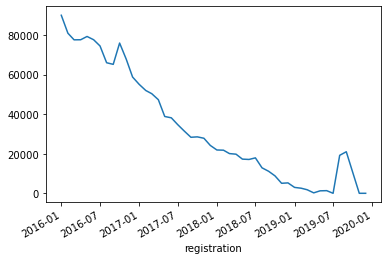

In [31]:
cars.groupby("registration").mean()["km"].plot()

In [32]:
# According to my research on the internet, there is not much outlier km information in cars under 2 years old. 
# In order to estimate the car prices correctly, the registration date was assigned to the cars under the age of 2 
# with more km according to 2.5 iqr.

for j, k in cars.groupby("registration").mean()["km"].items():
    if j > pd.Timestamp('2017-12-01'):
        c= cars[cars["registration"] == j]["km"]
        q25 = c.quantile(0.25)
        q75 = c.quantile(0.75)
        iqr = q75 -q25
        lower_bound = range(0, 301) # q25-(1.5*iqr(c))
        upper_bound = q75 + (2.5*iqr)
        for n in c:
            if n > upper_bound:
                for a, b in cars.groupby("registration").mean()["km"].items():
                    if n > b:
                        cars["registration"][cars["km"] == n] = a
                        break
# According to the research I made on the internet, I saw that there are a few new cars among the cars over 2 years old. 
# In order to estimate the prices correctly, new registration dates have been assigned to cars over 2 years old and 
# between 0-300 km.                        

    elif j < pd.Timestamp('2017-12-01'):
        lower_bound = range(0, 301) # q25-(1.5*iqr(c))
        c= cars[cars["registration"] == j]["km"]
        for n in c:
            if n in lower_bound:
                for a, b in cars.groupby("registration").mean()["km"].items():
                    if n > b:
                        cars["registration"][cars["km"] == n] = a
                        break

In [33]:
cars.groupby("registration").mean()["km"].items

<bound method Series.items of registration
2016-01-01    91209.316195
2016-02-01    81252.936475
2016-03-01    78085.760000
2016-04-01    78248.834630
2016-05-01    80057.342282
2016-06-01    77886.981693
2016-07-01    76131.445122
2016-08-01    67564.398551
2016-09-01    67110.386364
2016-10-01    76872.756579
2016-11-01    68020.459854
2016-12-01    59069.325758
2017-01-01    55576.788194
2017-02-01    52690.417614
2017-03-01    51242.212528
2017-04-01    48089.445652
2017-05-01    39439.042079
2017-06-01    38473.704835
2017-07-01    35165.581395
2017-08-01    32033.682243
2017-09-01    29267.710145
2017-10-01    28930.226027
2017-11-01    28951.446429
2017-12-01    25238.586207
2018-01-01    22200.375502
2018-02-01    22230.383838
2018-03-01    20639.464724
2018-04-01    20127.347349
2018-05-01    17813.858075
2018-06-01    17635.481557
2018-07-01    18490.920110
2018-08-01    13963.193252
2018-09-01    12590.170732
2018-10-01     9740.265116
2018-11-01     6662.612546
2018-12-01  

<AxesSubplot:xlabel='registration'>

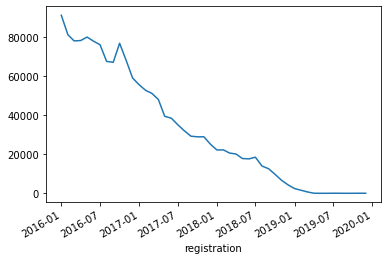

In [34]:
cars.groupby("registration").mean()["km"].plot() # We see that the km averages of cars younger than 2 years old are in order.

In [35]:
cars["registration"].value_counts(dropna = False)

2019-04-01    2187
2018-03-01     652
2018-05-01     613
2019-01-01     576
2016-03-01     550
2018-04-01     547
2016-04-01     514
2018-01-01     498
2018-02-01     495
2018-06-01     488
2016-02-01     488
2019-02-01     479
2016-05-01     447
2017-03-01     447
2016-06-01     437
2019-03-01     435
2017-05-01     404
2017-06-01     393
2016-01-01     389
2017-04-01     368
2018-07-01     363
2017-02-01     352
2018-08-01     326
2019-05-01     298
2018-12-01     291
2017-01-01     288
2018-11-01     271
2018-10-01     215
2017-07-01     215
2017-11-01     168
2016-07-01     164
2016-10-01     152
2019-06-01     148
2017-10-01     146
2017-12-01     145
2017-09-01     138
2016-08-01     138
2016-11-01     137
2016-12-01     132
2016-09-01     132
2018-09-01     123
2017-08-01     107
2019-07-01      46
2019-11-01       9
2019-12-01       4
2019-09-01       4
Name: registration, dtype: int64

In [36]:
cars["prev_owner"][(cars["km"] >= 0) & (cars["km"] <= 300)] = cars["prev_owner"][(cars["km"] >= 0) & (cars["km"] <= 300)]\
.fillna("no previous owner") 
cars["prev_owner"][cars["km"] > 300] = cars["prev_owner"][cars["km"] > 300].fillna("1 previous owner")  


In [37]:
cars["prev_owner"][cars.km == 0] = "no previous owner" # Prev_owner information has been rearranged according to km information

In [38]:
cars["prev_owner"].value_counts(dropna = False)

1 previous owner     11634
no previous owner     3494
2 previous owners      772
3 previous owners       17
4 previous owners        2
Name: prev_owner, dtype: int64

In [39]:
cars["vat"].value_counts(dropna = False)

VAT deductible      10980
NaN                  4513
Price negotiable      426
Name: vat, dtype: int64

In [40]:
def fill_most(df, col):
    
    return df[col].fillna(method = "bfill", inplace = True)


In [41]:
fill_most(cars, "vat") # In order to have a homogeneous distribution, the bfill method was used.

In [42]:
cars["vat"].value_counts()

VAT deductible      15083
Price negotiable      836
Name: vat, dtype: int64

In [43]:
# Fuel types in fuel column simplified.
def unique_values(item):
    
    x = item[1] if type(item) == list else item
    
    if "electric/gasoline" in x.lower():
        return "electric/gasoline"
    elif "cng" in x.lower():
        return "CNG"
    elif "lpg" in x.lower():
        return "LPG"
    elif "super" in x.lower():
        return "gasoline"
    elif "benzine" in x.lower(): 
        return "gasoline"
    elif "gasoline" in x.lower():
        return "gasoline"
    elif "diesel" in x.lower():
        return "diesel"
    elif "domestic" in x.lower():
        return "CNG"
    elif "biogas" in x.lower():
        return "LPG"
    elif "particulate filter" in x.lower():
        return "diesel"
    else:
        return x.lower()

In [44]:
cars["Fuel"].apply(unique_values).value_counts()

gasoline             8545
diesel               7300
CNG                    37
LPG                    27
others                  5
electric/gasoline       4
electric                1
Name: Fuel, dtype: int64

In [45]:
cars["Fuel2"] = cars["Fuel"].apply(unique_values) # fuel2 column created

In [46]:
cars.loc[(cars["Fuel2"] == "others")].head() # 1 diesel, 4 gasoline according to short_description

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2
819,Audi A1,1.4TDI Sportback /Euro6 /Navi /SHZ /PDC,Sedans,14388,VAT deductible,25684,2016-10-01,1 previous owner,66 kW,"[\n, \n]",...,NaN,NaN,"[[], [], []]","[Armrest, Cruise control, Electrical side mirr...","[Bluetooth, Hands-free equipment, On-board com...",NaN,NaN,[\n5\n],Used,others
2885,Audi A3,SPORTBACK 1.4 TFSI G-Tron S-Tronic Adrenalin S...,Compact,16400,VAT deductible,123748,2016-04-01,1 previous owner,81 kW,NaN,...,NaN,"[[], [], []]",[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[CD player, Hands-free equipment, On-board com...","[Alloy wheels, Sport package, Trailer hitch]","[ABS, Central door lock, Driver-side airbag, F...",[\n7\n],Used,others
10374,Opel Corsa,1.4 GLP Selective Pro 90,Sedans,11300,VAT deductible,0,2019-05-01,no previous owner,66 kW,"[\n24 months\n, \n126 g CO2/km (comb)\n]",...,"[[5.1 l/100 km (comb)], [6.5 l/100 km (city)],...",[\n126 g CO2/km (comb)\n],[\nEuro 6d-TEMP\n],"[Air conditioning, Cruise control, Electrical ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Voice Control]","[ABS, Adaptive headlights, Central door lock w...",[\n5\n],Pre-registered,others
11677,Opel Insignia,Edition,Other,18480,VAT deductible,14937,2018-02-01,1 previous owner,103 kW,NaN,...,NaN,NaN,"[[], [], []]","[Air conditioning, Cruise control, Electrical ...","[On-board computer, Radio, USB]","[Alloy wheels, Trailer hitch]","[Central door lock, Daytime running lights, Dr...",NaN,Used,others
14500,Renault Clio,TCe Energy GLP Limited 66kW 90CV,Sedans,10800,VAT deductible,13000,2018-06-01,1 previous owner,66 kW,"[\n12 months\n, \nEuro 6d-TEMP\n]",...,"[[4.7 l/100 km (comb)], [5.7 l/100 km (city)],...",[\n108 g CO2/km (comb)\n],[\nEuro 6d-TEMP\n],"[Air conditioning, Automatic climate control, ...","[Bluetooth, Hands-free equipment, Radio, Sound...","[Alloy wheels, Touch screen]","[ABS, Central door lock with remote control, D...",[\n5\n],Employee's,others


In [47]:
cars.loc[(cars["Fuel2"] == "others"), "Fuel2"] = ["diesel", "gasoline", "gasoline", "gasoline", "gasoline"]
# 1 diesel, 4 gasoline according to short_description

In [48]:
cars.drop("Fuel", axis = 1, inplace = True) # Since we no longer need the fuelcolumn, we drop it.

In [49]:
cars.head(1)

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2
0,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,56013,2016-01-01,2 previous owners,66 kW,"[\n, \n, \n4 (Green)\n]",...,"[[3.8 l/100 km (comb)], [4.3 l/100 km (city)],...",[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel


In [50]:
cars["hp"].sort_values()

13158     - kW
15472     - kW
15439     - kW
11183     - kW
15438     - kW
         ...  
15318    96 kW
15330    96 kW
15384    98 kW
15382    98 kW
15376    98 kW
Name: hp, Length: 15919, dtype: object

In [51]:
cars["hp"][cars["hp"] == "- kW"].replace("- kW", np.nan)

1269    NaN
2500    NaN
4259    NaN
7177    NaN
7670    NaN
         ..
15641   NaN
15647   NaN
15684   NaN
15791   NaN
15906   NaN
Name: hp, Length: 88, dtype: float64

In [52]:
cars["hp"].isnull().sum()

0

In [53]:
cars["hp"][cars["hp"] == "- kW"] = cars["hp"][cars["hp"] == "- kW"].replace("- kW", np.nan)

In [54]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [55]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "hp")

In [56]:
cars.hp.value_counts(dropna = False)

85 kW     2544
66 kW     2130
81 kW     1402
100 kW    1309
110 kW    1114
          ... 
115 kW       1
44 kW        1
4 kW         1
9 kW         1
195 kW       1
Name: hp, Length: 80, dtype: int64

In [57]:
cars["hp"].str.extract("(\d*)") # the numeric values are extracted
cars["hp"] = cars["hp"].str.extract("(\d*)")
cars["hp"] = cars["hp"].astype("int")

In [58]:
cars["hp"].head()

0     66
1    141
2     85
3     66
4     66
Name: hp, dtype: int32

In [59]:
cars.head(1)

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2
0,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,56013,2016-01-01,2 previous owners,66,"[\n, \n, \n4 (Green)\n]",...,"[[3.8 l/100 km (comb)], [4.3 l/100 km (city)],...",[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel


In [60]:
def unique_values(item):
    
    if type(item) == list:
        return ", ".join(item).strip(",").split()
        
    else:
        return str(item).strip(",").split()

In [61]:
cars.Warranty.apply(unique_values).str[0].str.replace("nan", "0").str.replace(",", "0").fillna("0")

0         0
1         0
2         0
3         0
4         0
         ..
15914    24
15915     0
15916     0
15917     0
15918     0
Name: Warranty, Length: 15919, dtype: object

In [62]:
cars.Warranty = cars.Warranty.apply(unique_values).str[0].str.replace("nan", "0").str.replace(",", "0").fillna("0")
# "0" assigned to nan and "," 

In [63]:
cars["Warranty"] = cars["Warranty"].astype("int") # returned int.

In [64]:
cars.loc[cars["car_type"] == "New", "Warranty"]

122       0
710      24
734       0
741      36
743       0
         ..
15892     0
15902     0
15907    36
15912    24
15914    24
Name: Warranty, Length: 1651, dtype: int32

In [65]:
cars.loc[cars["car_type"] == "New", "Warranty"] = 36 
# Considering that the warranty for new cars is 36 months on average, the warranty for all new cars has been 
# assigned as 36 months.

In [66]:
cars.loc[cars["car_type"] == "New", "Warranty"]

122      36
710      36
734      36
741      36
743      36
         ..
15892    36
15902    36
15907    36
15912    36
15914    36
Name: Warranty, Length: 1651, dtype: int32

In [67]:
# 36 months are assigned as a guarantee for all cars with a km of less than 500, registered in 2019
# No perivious owner is assigned as prev_owner
# new is assigned as car_type

In [68]:
cars.loc[((cars["registration"] >= pd.Timestamp('2019-01-01')) & (cars["registration"] <= pd.Timestamp('2019-12-01'))\
    &(cars["Warranty"] == 0) & (cars["car_type"] == "Used") & (cars["km"] < 500)), "Warranty"] = 36

In [69]:
cars.loc[((cars["registration"] >= pd.Timestamp('2019-01-01')) & (cars["registration"] <= pd.Timestamp('2019-12-01'))\
    &(cars["Warranty"] == 36) & (cars["car_type"] == "Used") & (cars["km"] < 500)), "prev_owner"] = "no previous owner"

In [70]:
cars.loc[((cars["registration"] >= pd.Timestamp('2019-01-01')) & (cars["registration"] <= pd.Timestamp('2019-12-01'))\
    &(cars["Warranty"] == 36) & (cars["car_type"] == "Used") & (cars["km"] < 500)), "car_type"] = "New"

In [71]:
cars.loc[((cars["registration"] >= pd.Timestamp('2018-01-01')) & (cars["registration"] <= pd.Timestamp('2018-12-01'))\
    &(cars["Warranty"] == 0) & (cars["car_type"] == "Used") & (cars["km"] < 500)), "Warranty"] = 36

In [72]:
cars.loc[((cars["registration"] >= pd.Timestamp('2018-01-01')) & (cars["registration"] <= pd.Timestamp('2018-12-01'))\
    &(cars["Warranty"] == 36) & (cars["car_type"] == "Used") & (cars["km"] < 500)), "prev_owner"] = "no previous owner"

In [73]:
cars.loc[((cars["registration"] >= pd.Timestamp('2018-01-01')) & (cars["registration"] <= pd.Timestamp('2018-12-01'))\
    &(cars["Warranty"] == 36) & (cars["car_type"] == "Used") & (cars["km"] < 500)), "car_type"] = "New"

In [74]:
cars.loc[:, "Warranty":].head(1)

,Warranty,Body Color,Paint Type,Upholstery,Nr. of Doors,Nr. of Seats,Gearing Type,Displacement,Cylinders,Weight,...,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2
0,0,"[\n, Black, \n]",[\nMetallic\n],"[\nCloth, Black\n]",[\n5\n],[\n5\n],"[\n, Automatic, \n]","[\n1,422 cc\n]",[\n3\n],"[\n1,220 kg\n]",...,"[[3.8 l/100 km (comb)], [4.3 l/100 km (city)],...",[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel


In [75]:
cars["Body Color"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n, Black, \n]     3745
[\n, Grey, \n]      3505
[\n, White, \n]     3406
[\n, Silver, \n]    1647
[\n, Blue, \n]      1431
[\n, Red, \n]        957
NaN                  597
[\n, Brown, \n]      289
[\n, Green, \n]      154
[\n, Beige, \n]      108
[\n, Yellow, \n]      51
[\n, Violet, \n]      18
[\n, Bronze, \n]       6
[\n, Orange, \n]       3
[\n, Gold, \n]         2
Name: Body Color, dtype: int64

In [76]:
def unique_values(item):
    
    if type(item) == list:
        return ", ".join(item).strip("\n,").split()
        
    else:
        return item

In [77]:
cars["Body Color"].apply(unique_values).str[0].str.replace(",", "")

0        Black
1          Red
2        Black
3        Brown
4        Black
         ...  
15914     Grey
15915     Grey
15916    White
15917     Grey
15918     Grey
Name: Body Color, Length: 15919, dtype: object

In [78]:
cars["Body Color"] = cars["Body Color"].apply(unique_values).str[0].str.replace(",", "")

In [79]:
cars["Body Color"].value_counts(dropna = False)

Black     3745
Grey      3505
White     3406
Silver    1647
Blue      1431
Red        957
NaN        597
Brown      289
Green      154
Beige      108
Yellow      51
Violet      18
Bronze       6
Orange       3
Gold         2
Name: Body Color, dtype: int64

In [80]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [81]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Body Color")

In [82]:
cars["Body Color"].value_counts(dropna = False)

Black     3877
Grey      3614
White     3531
Silver    1705
Blue      1535
Red        998
Brown      298
Green      163
Beige      114
Yellow      54
Violet      19
Bronze       6
Orange       3
Gold         2
Name: Body Color, dtype: int64

In [83]:
def unique_values(item):
    
    if type(item) == list:
        return ", ".join(item).strip("\n").split()
        
    else:
        return item

In [84]:
cars["Paint Type"].apply(unique_values).str[0] # data extracted from list

0        Metallic
1             NaN
2        Metallic
3        Metallic
4        Metallic
           ...   
15914    Metallic
15915    Metallic
15916         NaN
15917         NaN
15918    Metallic
Name: Paint Type, Length: 15919, dtype: object

In [85]:
cars["Paint Type"] = cars["Paint Type"].apply(unique_values).str[0]

In [86]:
cars["Paint Type"].value_counts(dropna = False)

Metallic     9794
NaN          5772
Uni/basic     347
Perl            6
Name: Paint Type, dtype: int64

In [87]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]


In [88]:
for i in cars["make_model"].unique(): # The NaNs were filled homagically.
    fill_most(cars, i, "Paint Type")

In [89]:
cars["Paint Type"].value_counts(dropna = False)

Metallic     15261
Uni/basic      617
Perl            41
Name: Paint Type, dtype: int64

In [90]:
cars.loc[:, "Warranty":].head(1)

,Warranty,Body Color,Paint Type,Upholstery,Nr. of Doors,Nr. of Seats,Gearing Type,Displacement,Cylinders,Weight,...,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2
0,0,Black,Metallic,"[\nCloth, Black\n]",[\n5\n],[\n5\n],"[\n, Automatic, \n]","[\n1,422 cc\n]",[\n3\n],"[\n1,220 kg\n]",...,"[[3.8 l/100 km (comb)], [4.3 l/100 km (city)],...",[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel


In [91]:
cars["Upholstery"]

0               [\nCloth, Black\n]
1                [\nCloth, Grey\n]
2               [\nCloth, Black\n]
3                              NaN
4               [\nCloth, Black\n]
                   ...            
15914                          NaN
15915                  [\nCloth\n]
15916    [\nFull leather, Black\n]
15917           [\nPart leather\n]
15918    [\nFull leather, Brown\n]
Name: Upholstery, Length: 15919, dtype: object

In [92]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n,").split(",")
        
    else:
        return item

In [93]:
cars["Upholstery"].apply(unique_values) # data extracted from list

0               [Cloth,  Black]
1                [Cloth,  Grey]
2               [Cloth,  Black]
3                           NaN
4               [Cloth,  Black]
                  ...          
15914                       NaN
15915                   [Cloth]
15916    [Full leather,  Black]
15917            [Part leather]
15918    [Full leather,  Brown]
Name: Upholstery, Length: 15919, dtype: object

In [94]:
cars["Upholstery"].apply(unique_values).str[0].value_counts(dropna = False)

Cloth           8423
NaN             3720
Part leather    1499
Full leather    1009
Black            491
Other            368
Grey             273
Velour            60
alcantara         57
Brown             12
Beige              3
White              2
Blue               2
Name: Upholstery, dtype: int64

In [95]:
# Two separate columns were created for Upholstery type and color.

In [96]:
cars.loc[(cars["Upholstery"].apply(unique_values).str[0] != "Cloth") & (cars["Upholstery"].apply(unique_values).str[0] != "Part leather")\
& (cars["Upholstery"].apply(unique_values).str[0] != "Full leather"), "Upholstery"] = np.nan

# The colors that appear in the upholstery type have been dropped

In [97]:
cars["upholstery_type"] = cars["Upholstery"].apply(unique_values).str[0]

In [98]:
cars["Upholstery"].apply(unique_values).str[0].value_counts(dropna = False)

Cloth           8423
NaN             4988
Part leather    1499
Full leather    1009
Name: Upholstery, dtype: int64

In [99]:
cars["Upholstery"].apply(unique_values).str[1].value_counts(dropna = False)

 Black     7517
NaN        6272
 Grey      1074
 Other      776
 Brown      194
 Beige       51
 Blue        14
 White       11
 Red          9
 Orange       1
Name: Upholstery, dtype: int64

In [100]:
cars["upholstery_color"] = cars["Upholstery"].apply(unique_values).str[1]

In [101]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [102]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "upholstery_type")

In [103]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "upholstery_color")

In [104]:
cars["upholstery_type"].value_counts(dropna = False)

Cloth           12295
Part leather     2181
Full leather     1443
Name: upholstery_type, dtype: int64

In [105]:
cars["upholstery_color"].value_counts(dropna = False)

 Black     12179
 Grey       1816
 Other      1342
 Brown       419
 Beige        88
 White        29
 Blue         29
 Red          16
 Orange        1
Name: upholstery_color, dtype: int64

In [106]:
cars.shape

(15919, 32)

In [107]:
cars.head(1)

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,56013,2016-01-01,2 previous owners,66,0,...,[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [108]:
cars.drop("Upholstery", axis = 1, inplace = True)
# Upholstery column dropped as we no longer needed it

In [109]:
"Upholstery" in cars

False

In [110]:
cars.loc[:, "Warranty":].head(1)

,Warranty,Body Color,Paint Type,Nr. of Doors,Nr. of Seats,Gearing Type,Displacement,Cylinders,Weight,Drive chain,...,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,0,Black,Metallic,[\n5\n],[\n5\n],"[\n, Automatic, \n]","[\n1,422 cc\n]",[\n3\n],"[\n1,220 kg\n]",[\nfront\n],...,[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [111]:
cars["Nr. of Doors"].value_counts(dropna =False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n5\n]    11575
[\n4\n]     3079
[\n3\n]      832
[\n2\n]      219
NaN          212
[\n7\n]        1
[\n1\n]        1
Name: Nr. of Doors, dtype: int64

In [112]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n,").split(",")
        
    else:
        return item

In [113]:
cars["Nr. of Doors"].apply(unique_values).str[0].value_counts(dropna = False) # data extracted from list

5      11575
4       3079
3        832
2        219
NaN      212
7          1
1          1
Name: Nr. of Doors, dtype: int64

In [114]:
cars["Nr. of Doors"] = cars["Nr. of Doors"].apply(unique_values).str[0]

In [115]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [116]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Nr. of Doors")

In [117]:
cars["Nr. of Doors"] = cars["Nr. of Doors"].astype("int")

In [118]:
cars["Nr. of Doors"].value_counts(dropna = False)

5    11724
4     3122
3      848
2      223
7        1
1        1
Name: Nr. of Doors, dtype: int64

In [119]:
cars[cars["Nr. of Doors"] == 7]["Nr. of Doors"]

15202    7
Name: Nr. of Doors, dtype: int32

In [120]:
cars.loc[15202, "Nr. of Doors"] = 5 #  The values thought to be entered incorrectly were corrected manually.

In [121]:
cars.loc[15202, "Nr. of Doors"]

5

In [122]:
cars[cars["Nr. of Doors"] == 1]["Nr. of Doors"] # The values thought to be entered incorrectly were corrected manually.

13782    1
Name: Nr. of Doors, dtype: int32

In [123]:
cars.loc[13782, "Nr. of Doors"] = 4

In [124]:
cars.loc[13782, "Nr. of Doors"]

4

In [125]:
cars["Nr. of Doors"].value_counts(dropna = False)

5    11725
4     3123
3      848
2      223
Name: Nr. of Doors, dtype: int64

In [126]:
cars.loc[:, "Warranty":].head(1)

,Warranty,Body Color,Paint Type,Nr. of Doors,Nr. of Seats,Gearing Type,Displacement,Cylinders,Weight,Drive chain,...,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,0,Black,Metallic,5,[\n5\n],"[\n, Automatic, \n]","[\n1,422 cc\n]",[\n3\n],"[\n1,220 kg\n]",[\nfront\n],...,[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [127]:
cars["Nr. of Seats"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n5\n]    13336
[\n4\n]     1125
NaN          977
[\n7\n]      362
[\n2\n]      116
[\n6\n]        2
[\n3\n]        1
Name: Nr. of Seats, dtype: int64

In [128]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n").split(",")
        
    else:
        return item

In [129]:
cars["Nr. of Seats"].apply(unique_values).str[0].value_counts(dropna = False) # data extracted from list

5      13336
4       1125
NaN      977
7        362
2        116
6          2
3          1
Name: Nr. of Seats, dtype: int64

In [130]:
cars["Nr. of Seats"] = cars["Nr. of Seats"].apply(unique_values).str[0]

In [131]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [132]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Nr. of Seats")

In [133]:
cars["Nr. of Seats"].value_counts(dropna = False)

5    14179
4     1192
7      415
2      130
6        2
3        1
Name: Nr. of Seats, dtype: int64

In [134]:
cars[cars["Nr. of Seats"]== 3]

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color


In [135]:
cars.loc[1636, "Nr. of Seats"]

'3'

In [136]:
cars.loc[1636, "Nr. of Seats"] = 5 # The values thought to be entered incorrectly were corrected manually.

In [137]:
cars.loc[1636, "Nr. of Seats"]

5

In [138]:
cars[cars["Nr. of Seats"]== 6] # The values thought to be entered incorrectly were corrected manually.

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color


In [139]:
cars.loc[[582, 15890], "Nr. of Seats"] = 5 # The values thought to be entered incorrectly were corrected manually.

In [140]:
cars.loc[[582, 15890], "Nr. of Seats"]

582      5
15890    5
Name: Nr. of Seats, dtype: object

In [141]:
cars["Nr. of Seats"] = cars["Nr. of Seats"].astype("int")

In [142]:
cars["Nr. of Seats"].dtype

dtype('int32')

In [143]:
cars.loc[:, "Warranty":].head(1)

,Warranty,Body Color,Paint Type,Nr. of Doors,Nr. of Seats,Gearing Type,Displacement,Cylinders,Weight,Drive chain,...,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,0,Black,Metallic,5,5,"[\n, Automatic, \n]","[\n1,422 cc\n]",[\n3\n],"[\n1,220 kg\n]",[\nfront\n],...,[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [144]:
cars["Gearing Type"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n, Manual, \n]            8153
[\n, Automatic, \n]         7297
[\n, Semi-automatic, \n]     469
Name: Gearing Type, dtype: int64

In [145]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n,").split()
        
    else:
        return item

In [146]:
cars["Gearing Type"].apply(unique_values).str[0].value_counts(dropna = False)

Manual            8153
Automatic         7297
Semi-automatic     469
Name: Gearing Type, dtype: int64

In [147]:
cars["Gearing Type"].apply(unique_values).str[0].value_counts(dropna = False)

Manual            8153
Automatic         7297
Semi-automatic     469
Name: Gearing Type, dtype: int64

In [148]:
cars["Gearing Type"] = cars["Gearing Type"].apply(unique_values).str[0]

In [149]:
cars["Gearing Type"].value_counts(dropna = False)

Manual            8153
Automatic         7297
Semi-automatic     469
Name: Gearing Type, dtype: int64

In [150]:
cars["Displacement"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n1,598 cc\n]     4761
[\n999 cc\n]       2438
[\n1,398 cc\n]     1314
[\n1,399 cc\n]      749
[\n1,229 cc\n]      677
                   ... 
[\n1,800 cc\n]        1
[\n140 cc\n]          1
[\n15,898 cc\n]       1
[\n1,686 cc\n]        1
[\n1,368 cc\n]        1
Name: Displacement, Length: 78, dtype: int64

In [151]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n")
        
    else:
        return item

In [152]:
cars["Displacement"].apply(unique_values) # data excracted from list

0        1,422 cc
1        1,798 cc
2        1,598 cc
3        1,422 cc
4        1,422 cc
           ...   
15914    1,997 cc
15915    1,798 cc
15916    1,997 cc
15917    1,997 cc
15918    1,798 cc
Name: Displacement, Length: 15919, dtype: object

In [153]:
cars["Displacement"].apply(unique_values).str.replace(",", "").str.extract("(\d*,\d*|\d*)")

,0
0,1422
1,1798
2,1598
3,1422
4,1422
...,...
15914,1997
15915,1798
15916,1997
15917,1997


In [154]:
cars["Displacement"] = cars["Displacement"].apply(unique_values).str.replace(",", "").str.extract("(\d*,\d*|\d*)")
# Numeric data that will be useful for us was excracted

In [155]:
cars["Displacement"].isnull().sum()

496

In [156]:
cars["Displacement"].value_counts().head()

1598    4761
999     2438
1398    1314
1399     749
1229     677
Name: Displacement, dtype: int64

In [157]:
def fill_most(df, model, col):
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [158]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Displacement")

In [159]:
cars["Displacement"] = cars["Displacement"].astype("int")

In [160]:
cars["Displacement"].dtype

dtype('int32')

In [161]:
sorted(cars["Displacement"].value_counts().index)

[1,
 2,
 54,
 122,
 139,
 140,
 160,
 890,
 898,
 899,
 900,
 929,
 973,
 995,
 996,
 997,
 998,
 999,
 1000,
 1100,
 1149,
 1195,
 1197,
 1198,
 1199,
 1200,
 1229,
 1239,
 1248,
 1300,
 1333,
 1350,
 1364,
 1368,
 1369,
 1390,
 1395,
 1396,
 1397,
 1398,
 1399,
 1400,
 1422,
 1461,
 1490,
 1495,
 1496,
 1498,
 1499,
 1500,
 1533,
 1568,
 1580,
 1584,
 1589,
 1596,
 1598,
 1599,
 1600,
 1618,
 1686,
 1696,
 1798,
 1800,
 1856,
 1896,
 1956,
 1968,
 1984,
 1995,
 1997,
 1998,
 2000,
 2480,
 2967,
 15898,
 16000]

In [162]:
# The values thought to be entered incorrectly were corrected manually.

cars.loc[(cars["Displacement"] == 1) & (cars["make_model"] == "Opel Insignia"), "Displacement"] = 1598
cars.loc[(cars["Displacement"] == 1) & (cars["make_model"] == "Renault Clio"), "Displacement"] = 1229
cars.loc[(cars["Displacement"] == 2) & (cars["make_model"] == "Opel Insignia"), "Displacement"] = 1998
cars.loc[(cars["Displacement"] == 2) & (cars["make_model"] == "Renault Clio"), "Displacement"] = 1490
cars.loc[(cars["Displacement"] == 160) & (cars["make_model"] == "Renault Espace"), "Displacement"] = 1600
cars.loc[(cars["Displacement"] == 122) & (cars["make_model"] == "Opel Corsa"), "Displacement"] = 1220
cars.loc[(cars["Displacement"] == 54) & (cars["make_model"] == "Renault Clio"), "Displacement"] = 1490
cars.loc[(cars["Displacement"] == 140) & (cars["make_model"] == "Opel Astra"), "Displacement"] = 1400
cars.loc[(cars["Displacement"] == 15898)& (cars["make_model"] == "Opel Astra"), "Displacement"] = 1598
cars.loc[(cars["Displacement"] == 139)& (cars["make_model"] == "Opel Astra"), "Displacement"] = 1398
cars.loc[(cars["Displacement"] == 16000)& (cars["make_model"] == "Opel Insignia"), "Displacement"] = 1598
cars.loc[(cars["Displacement"] == 2967)& (cars["make_model"] == "Opel Insignia"), "Displacement"] = 1598
cars.loc[(cars["Displacement"] == 1856), "Displacement"]  = 1598
cars.loc[(cars["Displacement"] == 1896), "Displacement"] = 1598

In [163]:
# Displacements simplified

def unique_values(item):

    
    if item >=890 and item <= 929:
        return 898
    elif item >=973 and item <= 1100:
        return 998
    elif item >=1149 and item <= 1239:
        return 1198
    elif item >=1248 and item <= 1333:
        return 1298
    elif item >=1350 and item <= 1422: 
        return 1398
    elif item >=1461 and item <= 1533:
        return 1498
    elif item >=1568 and item <= 1696:
        return 1598
    elif item >=1798 and item <= 1856:
        return 1798
    elif item >=1956 and item <= 2000:
        return 1998
    else:
        return item
    

In [164]:
cars["Displacement"].apply(unique_values) # Displacements simplified

0        1398
1        1798
2        1598
3        1398
4        1398
         ... 
15914    1998
15915    1798
15916    1998
15917    1998
15918    1798
Name: Displacement, Length: 15919, dtype: int64

In [165]:
cars["Displacement"] = cars["Displacement"].apply(unique_values)

In [166]:
cars.loc[:, "Weight":].head(1)

,Weight,Drive chain,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,"[\n1,220 kg\n]",[\nfront\n],"[[3.8 l/100 km (comb)], [4.3 l/100 km (city)],...",[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [167]:
cars["Cylinders"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n4\n]    8105
NaN        5680
[\n3\n]    2104
[\n5\n]      22
[\n6\n]       3
[\n2\n]       2
[\n8\n]       2
[\n1\n]       1
Name: Cylinders, dtype: int64

In [168]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n")
        
    else:
        return item

In [169]:
cars["Cylinders"].apply(unique_values).value_counts(dropna = False) # data extracted from list

4      8105
NaN    5680
3      2104
5        22
6         3
2         2
8         2
1         1
Name: Cylinders, dtype: int64

In [170]:
cars["Cylinders"] = cars["Cylinders"].apply(unique_values)

In [171]:
cars[cars["Cylinders"] == "5"] # The values thought to be entered incorrectly were corrected manually.

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
3587,Audi A3,RS 3 SPB 2.5 TFSI quattro S tronic,Sedans,64900,VAT deductible,35000,2018-04-01,1 previous owner,294,0,...,[\nEuro 6\n],"[Air conditioning, Seat ventilation, Split rea...",[Radio],[Alloy wheels],"[Adaptive Cruise Control, Alarm system, Centra...",[\n7\n],Used,gasoline,Full leather,Black
3590,Audi A3,RS 3 SPB Quattro S Tronic,Sedans,62900,VAT deductible,700,2019-04-01,1 previous owner,294,0,...,[\nEuro 6d-TEMP\n],"[Air conditioning, Seat ventilation, Split rea...","[Bluetooth, Radio]",[Alloy wheels],"[ABS, Adaptive Cruise Control, Alarm system, C...",[\n7\n],Used,gasoline,Part leather,Black
3592,Audi A3,RS 3 SPB 2.5 TFSI quattro S tronic ! FAST VOLL,Sedans,56900,VAT deductible,5200,2018-08-01,1 previous owner,294,0,...,[\nEuro 6\n],"[Air conditioning, Air suspension, Armrest, Au...","[Bluetooth, CD player, Digital radio, Hands-fr...","[Alloy wheels, Shift paddles, Sport package, S...","[ABS, Adaptive Cruise Control, Adaptive headli...",[\n7\n],Used,gasoline,Full leather,Black
3593,Audi A3,RS 3 SPB 2.5 TFSI quattro S tronic,Sedans,58500,VAT deductible,10000,2018-10-01,1 previous owner,294,0,...,[\nEuro 6\n],"[Air conditioning, Seat ventilation, Split rea...",[Radio],[Alloy wheels],"[Adaptive Cruise Control, Alarm system, Centra...",[\n7\n],Used,gasoline,Full leather,Black
3595,Audi A3,RS 3 SPB 2.5 TFSI quattro S tronic,Station wagon,63900,VAT deductible,10,2019-06-01,1 previous owner,294,24,...,[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, CD player, Digital radio, Hands-fr...","[Alloy wheels, Shift paddles, Ski bag, Sport p...","[ABS, Adaptive Cruise Control, Adaptive headli...",[\n7\n],Used,gasoline,Part leather,Black
3596,Audi A3,RS 3 SPB 2.5 TFSI quattro S tronic,Sedans,57400,Price negotiable,63000,2018-01-01,1 previous owner,294,0,...,[\nEuro 6\n],"[Air conditioning, Air suspension, Armrest, Au...","[Bluetooth, CD player, Hands-free equipment, O...","[Alloy wheels, Sport seats, Sport suspension, ...","[ABS, Adaptive Cruise Control, Adaptive headli...",[\n7\n],Used,gasoline,Full leather,Black
3598,Audi A3,RS 3 SPB 2.5 TFSI quattro S tronic,Sedans,55000,VAT deductible,24000,2018-01-01,1 previous owner,294,0,...,[\nEuro 6\n],"[Air conditioning, Seat ventilation, Split rea...",[Radio],[Alloy wheels],"[Adaptive Cruise Control, Alarm system, Centra...",[\n7\n],Used,gasoline,Part leather,Black
3599,Audi A3,RS 3 Sedan 2.5 TFSI quattro S tronic,Sedans,55000,VAT deductible,30000,2018-03-01,1 previous owner,294,0,...,[\nEuro 6\n],"[Air conditioning, Seat ventilation, Split rea...",[Radio],[Alloy wheels],"[Adaptive Cruise Control, Alarm system, Centra...",[\n7\n],Used,gasoline,Part leather,Black
3600,Audi A3,RS 3 Sedan 2.5 TFSI quattro S tronic,Sedans,53000,VAT deductible,4000,2019-01-01,1 previous owner,294,0,...,[\nEuro 6\n],"[Air conditioning, Air suspension, Armrest, Au...","[Bluetooth, CD player, Digital radio, Hands-fr...","[Alloy wheels, Catalytic Converter, Shift padd...","[Adaptive Cruise Control, Adaptive headlights,...",[\n7\n],Used,gasoline,Part leather,Black
3601,Audi A3,RS 3 SPB 2.5 TFSI quattro S tronic,Sedans,51900,VAT deductible,19000,2018-05-01,1 previous owner,294,0,...,[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Digital radio, Hands-free equipmen...","[Alloy wheels, Catalytic Converter, Shift padd...","[ABS, Adaptive Cruise Control, Adaptive headli...",[\n7\n],Used,gasoline,Part leather,Black


In [172]:
cars.loc[14480, "Cylinders"] = "4" # The values thought to be entered incorrectly were corrected manually.

In [173]:
cars.loc[[10771, 10826, 12897], "Cylinders"] = "4" # The values thought to be entered incorrectly were corrected manually.

In [174]:
cars.loc[[10771, 10826, 12897], "Cylinders"]

10771    4
10826    4
12897    4
Name: Cylinders, dtype: object

In [175]:
cars.loc[[535, 15055], "Cylinders"] = "4" # The values thought to be entered incorrectly were corrected manually.

In [176]:
cars.loc[[9956, 11342, 15835], "Cylinders"] ="4" # The values thought to be entered incorrectly were corrected manually.

In [177]:
cars.loc[[9956, 11342, 15835], "Cylinders"]

9956     4
11342    4
15835    4
Name: Cylinders, dtype: object

In [178]:
cars.loc[cars["make_model"] == "Audi A2","Cylinders"] = "4" # The values thought to be entered incorrectly were corrected manually.

In [179]:
def fill_most(df, model, col):
   
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [180]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Cylinders")

In [181]:
cars["Cylinders"].value_counts(dropna= False)

4    12578
3     3319
5       22
Name: Cylinders, dtype: int64

In [182]:
cars["Cylinders"] = cars["Cylinders"].astype("int")

In [183]:
cars.loc[:, "Weight":].head(1)

,Weight,Drive chain,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,"[\n1,220 kg\n]",[\nfront\n],"[[3.8 l/100 km (comb)], [4.3 l/100 km (city)],...",[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [184]:
cars["Weight"].value_counts(dropna = False).head()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN               6974
[\n1,163 kg\n]     574
[\n1,360 kg\n]     356
[\n1,165 kg\n]     301
[\n1,335 kg\n]     242
Name: Weight, dtype: int64

In [185]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n")
        
    else:
        return item

In [186]:
cars["Weight"].apply(unique_values) # data exctracted from list

0        1,220 kg
1        1,255 kg
2             NaN
3        1,195 kg
4             NaN
           ...   
15914    1,758 kg
15915    1,708 kg
15916         NaN
15917    1,758 kg
15918    1,685 kg
Name: Weight, Length: 15919, dtype: object

In [187]:
cars["Weight"].apply(unique_values).str.replace(",", "").str.extract("(\d*)")
# Numeric data that will be useful for us was excracted

,0
0,1220
1,1255
2,NaN
3,1195
4,NaN
...,...
15914,1758
15915,1708
15916,NaN
15917,1758


In [188]:
cars["Weight"] = cars["Weight"].apply(unique_values).str.replace(",", "").str.extract("(\d*)")

In [189]:
cars["Weight"].value_counts().index

Index(['1163', '1360', '1165', '1335', '1135', '1199', '1734', '1180', '1503',
       '1350',
       ...
       '1132', '1507', '1792', '2275', '1476', '1397', '1207', '1257', '1819',
       '1420'],
      dtype='object', length=434)

In [190]:
def fill_most(df, model, col):
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [191]:
cars.loc[cars["make_model"] == "Audi A2","Weight"] = 1100 
# The values thought to be entered incorrectly were corrected manually.

In [192]:
cars.loc[cars["make_model"] == "Renault Duster","Weight"] = 1205 
# The values thought to be entered incorrectly were corrected manually.

In [193]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Weight")

In [194]:
cars["Weight"] = cars["Weight"].astype("int")

In [195]:
cars[cars.make_model == "Audi A1"]["Weight"]

0       1220
1       1255
2       1165
3       1195
4       1165
        ... 
2609    1165
2610    1165
2611    1135
2612    1165
2613    1136
Name: Weight, Length: 2614, dtype: int32

In [196]:
cars.loc[[8355, 12779], "Weight"] = [1163, 1503]
# The values thought to be entered incorrectly were corrected manually.

In [197]:
cars.loc[1143, "Weight"] = 1165
# The values thought to be entered incorrectly were corrected manually.

In [198]:
cars.loc[:, "Weight":].head(1)

,Weight,Drive chain,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,1220,[\nfront\n],"[[3.8 l/100 km (comb)], [4.3 l/100 km (city)],...",[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [199]:
cars["Drive chain"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\nfront\n]    8886
NaN            6858
[\n4WD\n]       171
[\nrear\n]        4
Name: Drive chain, dtype: int64

In [200]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n")
        
    else:
        return item

In [201]:
cars["Drive chain"].apply(unique_values).value_counts(dropna =False) # data extracted from list

front    8886
NaN      6858
4WD       171
rear        4
Name: Drive chain, dtype: int64

In [202]:
cars["Drive chain"] = cars["Drive chain"].apply(unique_values)

In [203]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [204]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Drive chain")

In [205]:
cars["Drive chain"].value_counts(dropna = False)

front    15581
4WD        333
rear         5
Name: Drive chain, dtype: int64

In [206]:
cars.loc[:, "Weight":].head(1)

,Weight,Drive chain,Consumption,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,1220,front,"[[3.8 l/100 km (comb)], [4.3 l/100 km (city)],...",[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [207]:
cars["Consumption"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[[3.9 l/100 km (comb)], [4.1 l/100 km (city)], [3.7 l/100 km (country)]]              304
[[4.2 l/100 km (comb)], [5 l/100 km (city)], [3.7 l/100 km (country)]]                276
[[5.4 l/100 km (comb)], [6.8 l/100 km (city)], [4.5 l/100 km (country)]]              257
[[3.8 l/100 km (comb)], [4.3 l/100 km (city)], [3.5 l/100 km (country)]]              253
[[4.7 l/100 km (comb)], [5.1 l/100 km (city)], [4.4 l/100 km (country)]]              244
                                                                                     ... 
[[], [], [5.6 l/100 km (country)]]                                                      1
[\n, 6.5 l/100 km (comb), \n, 8.1 l/100 km (city), \n, 5.5 l/100 km (country), \n]      1
[[3.5 l/100 km (comb)], [3.7 l/100 km (city)], [3.3 l/100 km (country)]]                1
[[3.9 l/100 km (comb)], [4.5 l/100 km (city)], [3.7 l/100 km (country)]]                1
[[5.4 l/100 km (comb)], [6.1 l/100 km (city)], [5 l/100 km (country)]]                  1
Name: Cons

In [208]:
def unique_values(item):
    
    if type(item) == list:
        return  str(item)
        
    else:
        return item
        

In [209]:
cars["Consumption"].apply(unique_values).head() # data extracted from list

0    [['3.8 l/100 km (comb)'], ['4.3 l/100 km (city...
1    [['5.6 l/100 km (comb)'], ['7.1 l/100 km (city...
2    [['3.8 l/100 km (comb)'], ['4.4 l/100 km (city...
3    [['3.8 l/100 km (comb)'], ['4.3 l/100 km (city...
4    [['4.1 l/100 km (comb)'], ['4.6 l/100 km (city...
Name: Consumption, dtype: object

In [210]:
x = cars["Consumption"].apply(unique_values).str.extract("(\d+.\d*|\d+).*'(\d+.\d*|\d+).*'(\d+.\d*|\d+)")
x # Numeric data that will be useful for us was extracted

,0,1,2
0,3.8,4.3,3.5
1,5.6,7.1,4.7
2,3.8,4.4,3.4
3,3.8,4.3,3.5
4,4.1,4.6,3.8
...,...,...,...
15914,5.3,6.2,4.7
15915,7.4,9.2,6.3
15916,5.3,6.2,4.7
15917,5.3,6.2,4.7


In [211]:
x_new = x.rename(columns = {0 : "comb", 1: "city", 2: "country"}) 
# new column names assigned to newly created dataframe

In [212]:
x_new

,comb,city,country
0,3.8,4.3,3.5
1,5.6,7.1,4.7
2,3.8,4.4,3.4
3,3.8,4.3,3.5
4,4.1,4.6,3.8
...,...,...,...
15914,5.3,6.2,4.7
15915,7.4,9.2,6.3
15916,5.3,6.2,4.7
15917,5.3,6.2,4.7


In [213]:
x_new["comb"] = x_new["comb"].astype("float")
x_new["city"] = x_new["city"].astype("float")
x_new["country"] = x_new["country"].astype("float") # new columns converted to float

In [214]:
x_new["comb"].dtype

dtype('float64')

In [215]:
cars.head(1)

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color
0,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,56013,2016-01-01,2 previous owners,66,0,...,[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black


In [216]:
cars = cars.join(x_new) # new columns joined to cars dataframe

In [217]:
cars.drop("Consumption", axis = 1, inplace = True)
# Consumption column was dropped as we no longer needed it

In [218]:
cars.head(1)

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color,comb,city,country
0,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,56013,2016-01-01,2 previous owners,66,0,...,"[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black,3.8,4.3,3.5


In [219]:
def fill_most(df, model, col):
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [220]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "comb")

In [221]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "city")

In [222]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "country")

In [223]:
cars["country"].value_counts(dropna = False).head()

4.5    1533
3.7    1500
4.2    1443
3.8    1179
4.4    1137
Name: country, dtype: int64

In [224]:
cars.loc[:, "Weight":].head(1)

,Weight,Drive chain,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color,comb,city,country
0,1220,front,[\n99 g CO2/km (comb)\n],[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black,3.8,4.3,3.5


In [225]:
cars["CO2 Emission"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                            1808
[\n120 g CO2/km (comb)\n]       740
[[], [], []]                    628
[\n99 g CO2/km (comb)\n]        545
[\n97 g CO2/km (comb)\n]        537
                               ... 
[\n193 g CO2/km (comb)\n]         1
[\n171 g CO2/km (comb)\n]         1
[\n990 g CO2/km (comb)\n]         1
[\n1,060 g CO2/km (comb)\n]       1
[\n183 g CO2/km (comb)\n]         1
Name: CO2 Emission, Length: 124, dtype: int64

In [226]:
def unique_values(item):
    
    if type(item) == list:
        return str(item)
        
    else:
        return item

In [227]:
cars["CO2 Emission"].apply(unique_values)

0         ['\n99 g CO2/km (comb)\n']
1        ['\n129 g CO2/km (comb)\n']
2         ['\n99 g CO2/km (comb)\n']
3         ['\n99 g CO2/km (comb)\n']
4        ['\n109 g CO2/km (comb)\n']
                    ...             
15914    ['\n139 g CO2/km (comb)\n']
15915    ['\n168 g CO2/km (comb)\n']
15916    ['\n139 g CO2/km (comb)\n']
15917    ['\n139 g CO2/km (comb)\n']
15918    ['\n153 g CO2/km (comb)\n']
Name: CO2 Emission, Length: 15919, dtype: object

In [228]:
cars["CO2 Emission"].apply(unique_values).str.extract("(\d+)") 
# Numeric data that will be useful for us was extracted

,0
0,99
1,129
2,99
3,99
4,109
...,...
15914,139
15915,168
15916,139
15917,139


In [229]:
cars["CO2 Emission"] = cars["CO2 Emission"].apply(unique_values).str.extract("(\d+)")

In [230]:
cars["CO2 Emission"].value_counts(dropna = False)

NaN    2436
120     740
99      545
97      537
104     501
       ... 
253       1
177       1
239       1
990       1
51        1
Name: CO2 Emission, Length: 120, dtype: int64

In [231]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [232]:
cars.loc[cars.make_model == "Audi A2", "CO2 Emission"] = "104" # value entered manually

In [233]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "CO2 Emission")

In [234]:
cars["CO2 Emission"] = cars["CO2 Emission"].astype("int")

In [235]:
cars.loc[:, "Weight":].head(1)

,Weight,Drive chain,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color,comb,city,country
0,1220,front,99,[\nEuro 6\n],"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black,3.8,4.3,3.5


In [236]:
cars["Emission Class"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\nEuro 6\n]          10139
NaN                    3021
[\nEuro 6d-TEMP\n]     1845
[[], [], []]            607
[\nEuro 6c\n]           127
[\nEuro 5\n]             78
[\nEuro 6d\n]            62
[\nEuro 4\n]             40
Name: Emission Class, dtype: int64

In [237]:
def unique_values(item):
    
    if type(item) == list:
        return str(item)
        
    else:
        return item

In [238]:
cars["Emission Class"].apply(unique_values).replace("[[], [], []]", np.nan).str.extract(".{4}(.*).{4}").value_counts()
# Numeric data that will be useful for us was extracted

Euro 6          10139
Euro 6d-TEMP     1845
Euro 6c           127
Euro 5             78
Euro 6d            62
Euro 4             40
dtype: int64

In [239]:
cars["Emission Class"] = cars["Emission Class"].apply(unique_values).replace("[[], [], []]", np.nan).str.extract(".{4}(.*).{4}")

In [240]:
cars["Emission Class"].value_counts(dropna = False)

Euro 6          10139
NaN              3628
Euro 6d-TEMP     1845
Euro 6c           127
Euro 5             78
Euro 6d            62
Euro 4             40
Name: Emission Class, dtype: int64

In [241]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [242]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Emission Class")

In [243]:
cars["Emission Class"].value_counts(dropna = False)

Euro 6          12975
Euro 6d-TEMP     2547
Euro 6c           171
Euro 5             96
Euro 6d            87
Euro 4             43
Name: Emission Class, dtype: int64

In [244]:
cars.loc[:, "Weight":].head(1)

,Weight,Drive chain,CO2 Emission,Emission Class,\nComfort & Convenience\n,\nEntertainment & Media\n,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color,comb,city,country
0,1220,front,99,Euro 6,"[Air conditioning, Armrest, Automatic climate ...","[Bluetooth, Hands-free equipment, On-board com...","[Alloy wheels, Catalytic Converter, Voice Cont...","[ABS, Central door lock, Daytime running light...",NaN,Used,diesel,Cloth,Black,3.8,4.3,3.5


In [245]:
cars["\nComfort & Convenience\n"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                                                                                                                                                                                                                                                                                                                                                     920
[Air conditioning, Electrical side mirrors, Hill Holder, Power windows]                                                                                                                                                                                                                                                                                                 216
[Air conditioning, Electrical side mirrors, Power windows]                                                                                                                                                                                                                      

In [246]:
def unique_values(item):
    
    if type(item) == list:
        return ",".join(item)
        
    else:
        return item


In [247]:
cars["\nComfort & Convenience\n"].apply(unique_values) # data excracted from list

0        Air conditioning,Armrest,Automatic climate con...
1        Air conditioning,Automatic climate control,Hil...
2        Air conditioning,Cruise control,Electrical sid...
3        Air suspension,Armrest,Auxiliary heating,Elect...
4        Air conditioning,Armrest,Automatic climate con...
                               ...                        
15914    Air conditioning,Automatic climate control,Cru...
15915    Air conditioning,Automatic climate control,Cru...
15916    Air conditioning,Armrest,Automatic climate con...
15917    Air conditioning,Automatic climate control,Cru...
15918    Air conditioning,Automatic climate control,Cru...
Name: \nComfort & Convenience\n, Length: 15919, dtype: object

In [248]:
cars["\nComfort & Convenience\n"] = cars["\nComfort & Convenience\n"].apply(unique_values)

In [249]:
cars["\nComfort & Convenience\n"][0]

'Air conditioning,Armrest,Automatic climate control,Cruise control,Electrical side mirrors,Hill Holder,Leather steering wheel,Light sensor,Multi-function steering wheel,Navigation system,Park Distance Control,Parking assist system sensors rear,Power windows,Rain sensor,Seat heating,Start-stop system'

In [250]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [251]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "\nComfort & Convenience\n")

In [252]:
cars["\nComfort & Convenience\n"].value_counts(dropna = False)


Air conditioning,Electrical side mirrors,Hill Holder,Power windows                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                238
Air conditioning,Electrical side mirrors,Power windows                                                                                                                                                                                                                                                                                                                                                            

In [253]:
cars["\nEntertainment & Media\n"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                                                                      1374
[Bluetooth, Hands-free equipment, On-board computer, Radio, USB]                         1282
[Bluetooth, Hands-free equipment, MP3, On-board computer, Radio, USB]                     982
[Bluetooth, CD player, Hands-free equipment, MP3, On-board computer, Radio, USB]          783
[On-board computer, Radio]                                                                487
                                                                                         ... 
[Bluetooth, MP3, On-board computer, Sound system, USB]                                      1
[CD player, Hands-free equipment, On-board computer, Radio, Sound system, Television]       1
[Bluetooth, Digital radio, On-board computer, Sound system, USB]                            1
[CD player, Hands-free equipment, MP3, Radio, USB]                                          1
[CD player, Digital radio, Radio]                           

In [254]:
def unique_values(item):
    
    if type(item) == list:
        return ",".join(item)
        
    else:
        return item

In [255]:
cars["\nEntertainment & Media\n"].apply(unique_values) # data withdrawn from list

0        Bluetooth,Hands-free equipment,On-board comput...
1        Bluetooth,Hands-free equipment,On-board comput...
2                                    MP3,On-board computer
3        Bluetooth,CD player,Hands-free equipment,MP3,O...
4        Bluetooth,CD player,Hands-free equipment,MP3,O...
                               ...                        
15914    Bluetooth,Digital radio,Hands-free equipment,O...
15915    Bluetooth,Digital radio,Hands-free equipment,R...
15916    Bluetooth,Hands-free equipment,On-board comput...
15917                    Bluetooth,Digital radio,Radio,USB
15918                                                  USB
Name: \nEntertainment & Media\n, Length: 15919, dtype: object

In [256]:
cars["\nEntertainment & Media\n"] = cars["\nEntertainment & Media\n"].apply(unique_values)

In [257]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [258]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "\nEntertainment & Media\n")

In [259]:
cars["\nEntertainment & Media\n"].value_counts(dropna = False)

Bluetooth,Hands-free equipment,On-board computer,Radio,USB                  1411
Bluetooth,Hands-free equipment,MP3,On-board computer,Radio,USB              1054
Bluetooth,CD player,Hands-free equipment,MP3,On-board computer,Radio,USB     832
On-board computer                                                            548
Radio                                                                        530
                                                                            ... 
Bluetooth,Digital radio,MP3,Sound system,USB                                   1
CD player,Hands-free equipment,On-board computer,Sound system                  1
Bluetooth,Sound system,USB                                                     1
CD player,Hands-free equipment,MP3,On-board computer                           1
Hands-free equipment,MP3,On-board computer,Sound system,USB                    1
Name: \nEntertainment & Media\n, Length: 346, dtype: int64

In [260]:
cars["\nExtras\n"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[Alloy wheels]                                                                                         3245
NaN                                                                                                    2962
[Alloy wheels, Touch screen]                                                                            697
[Alloy wheels, Voice Control]                                                                           577
[Alloy wheels, Touch screen, Voice Control]                                                             541
                                                                                                       ... 
[Alloy wheels, Sport suspension, Touch screen, Trailer hitch, Voice Control]                              1
[Alloy wheels, Catalytic Converter, Handicapped enabled, Touch screen, Voice Control, Winter tyres]       1
[Ski bag, Sport suspension]                                                                               1
[Alloy wheels, Sport package

In [261]:
def unique_values(item):
    
    if type(item) == list:
        return ",".join(item)
        
    else:
        return item

In [262]:
cars["\nExtras\n"].apply(unique_values) # data extracted from list

0           Alloy wheels,Catalytic Converter,Voice Control
1        Alloy wheels,Sport seats,Sport suspension,Voic...
2                               Alloy wheels,Voice Control
3                   Alloy wheels,Sport seats,Voice Control
4        Alloy wheels,Sport package,Sport suspension,Vo...
                               ...                        
15914                            Alloy wheels,Touch screen
15915              Alloy wheels,Touch screen,Voice Control
15916                                         Alloy wheels
15917                            Alloy wheels,Touch screen
15918                            Alloy wheels,Touch screen
Name: \nExtras\n, Length: 15919, dtype: object

In [263]:
cars["\nExtras\n"] = cars["\nExtras\n"].apply(unique_values)

In [264]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [265]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "\nExtras\n")

In [266]:
cars["\nExtras\n"].value_counts(dropna = False)

Alloy wheels                                                                         3877
Alloy wheels,Touch screen                                                             839
Alloy wheels,Voice Control                                                            709
Alloy wheels,Touch screen,Voice Control                                               637
Roof rack                                                                             566
                                                                                     ... 
Alloy wheels,Catalytic Converter,Sport package,Trailer hitch                            1
Alloy wheels,Sport seats,Sport suspension,Touch screen,Voice Control,Winter tyres       1
Alloy wheels,Catalytic Converter,Shift paddles,Ski bag,Touch screen                     1
Alloy wheels,Cab or rented Car,Sport seats,Touch screen                                 1
Alloy wheels,Shift paddles,Sport seats,Sport suspension,Trailer hitch                   1
Name: \nEx

In [267]:
cars["\nSafety & Security\n"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


NaN                                                                                                                                                                                                                                                                                                                                                                                        982
[ABS, Central door lock, Daytime running lights, Driver-side airbag, Electronic stability control, Fog lights, Immobilizer, Isofix, Passenger-side airbag, Power steering, Side airbag, Tire pressure monitoring system, Traction control]                                                                                                                                                 538
[ABS, Central door lock, Daytime running lights, Driver-side airbag, Electronic stability control, Immobilizer, Isofix, Passenger-side airbag, Power steering, Side airbag, Tire pressure monitoring system, Traction control]            

In [268]:
def unique_values(item):
    
    if type(item) == list:
        return ",".join(item)
        
    else:
        return item

In [269]:
cars["\nSafety & Security\n"].apply(unique_values) # data extracted from list

0        ABS,Central door lock,Daytime running lights,D...
1        ABS,Central door lock,Central door lock with r...
2        ABS,Central door lock,Daytime running lights,D...
3        ABS,Alarm system,Central door lock with remote...
4        ABS,Central door lock,Driver-side airbag,Elect...
                               ...                        
15914    ABS,Central door lock,Central door lock with r...
15915    ABS,Adaptive Cruise Control,Blind spot monitor...
15916    ABS,Adaptive Cruise Control,Blind spot monitor...
15917    ABS,Blind spot monitor,Driver-side airbag,Elec...
15918    ABS,Blind spot monitor,Daytime running lights,...
Name: \nSafety & Security\n, Length: 15919, dtype: object

In [270]:
cars["\nSafety & Security\n"] = cars["\nSafety & Security\n"].apply(unique_values)

In [271]:
def fill_most(df, model, col):
    
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(method = "ffill")
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [272]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "\nSafety & Security\n")

In [273]:
cars["\nSafety & Security\n"].value_counts(dropna = False)

ABS,Central door lock,Daytime running lights,Driver-side airbag,Electronic stability control,Fog lights,Immobilizer,Isofix,Passenger-side airbag,Power steering,Side airbag,Tire pressure monitoring system,Traction control                                                      563
ABS,Central door lock,Daytime running lights,Driver-side airbag,Electronic stability control,Immobilizer,Isofix,Passenger-side airbag,Power steering,Side airbag,Tire pressure monitoring system,Traction control                                                                 510
ABS,Central door lock,Daytime running lights,Driver-side airbag,Electronic stability control,Fog lights,Immobilizer,Isofix,LED Daytime Running Lights,Passenger-side airbag,Power steering,Side airbag,Tire pressure monitoring system,Traction control                           290
ABS,Central door lock,Daytime running lights,Driver-side airbag,Electronic stability control,Immobilizer,Isofix,Passenger-side airbag,Power steering,Side airbag,Tire 

In [274]:
cars["Gears"].value_counts(dropna = False)

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[\n6\n]     5822
NaN         4712
[\n5\n]     3239
[\n7\n]     1908
[\n8\n]      224
[\n9\n]        6
[\n4\n]        2
[\n3\n]        2
[\n1\n]        2
[\n50\n]       1
[\n2\n]        1
Name: Gears, dtype: int64

In [275]:
def unique_values(item):
    
    if type(item) == list:
        return "".join(item).strip("\n")
        
    else:
        return item

In [276]:
cars["Gears"].apply(unique_values).value_counts(dropna = False) # data extracted from list

6      5822
NaN    4712
5      3239
7      1908
8       224
9         6
4         2
3         2
1         2
2         1
50        1
Name: Gears, dtype: int64

In [277]:
cars["Gears"] = cars["Gears"].apply(unique_values)

In [278]:
cars.loc[cars.Gears == "1", ["Gears","Gearing Type", "make_model", "Cylinders", "hp"]].head(50)

,Gears,Gearing Type,make_model,Cylinders,hp
8921,1,Semi-automatic,Opel Corsa,4,66
14375,1,Automatic,Renault Clio,4,147


In [279]:
cars.loc[[14495, 9812, 15822, 15823, 15817, 15845, 8921, 14375, 215, 1033, 10151], "Gears"] =\
["5", "5", "6","6", "6", "6", "6", "5", "7","7", "6"] # The values thought to be entered incorrectly were corrected manually.

In [280]:
cars.loc[[14495, 9812, 15822, 15823, 15817, 15845, 8921, 14375, 215, 1033, 10151], "Gears"]

14495    5
9812     5
15822    6
15823    6
15817    6
15845    6
8921     6
14375    5
215      7
1033     7
10151    6
Name: Gears, dtype: object

In [281]:
def fill_most(df, model, grtyp, col):
    
    df[col][(df["make_model"] == model) & (df["Gearing Type"] == grtyp)] = df[col][(df["make_model"] == model)  & \
        (df["Gearing Type"] == grtyp)].fillna(method = "ffill")
    return df[col][(df["make_model"] == model) & (df["Gearing Type"] == grtyp)]

In [282]:
cars.loc[cars.make_model == "Audi A2", "Gears"] = "5"

In [283]:
for i in cars["make_model"].unique():
    for j in cars["Gearing Type"].unique():
        fill_most(cars, i, j, "Gears")

In [284]:
cars.Gears.value_counts(dropna= False)

6      8384
5      4388
7      2837
8       283
NaN      16
9        11
Name: Gears, dtype: int64

In [285]:
def fill_most(df, model, col):
    x = df[col][df["make_model"] == model].mode()
    df[col][df["make_model"] == model] = df[col][df["make_model"] == model].fillna(x[0])
    return df[col][df["make_model"] == model]

In [286]:
for i in cars["make_model"].unique():
    fill_most(cars, i, "Gears")

In [287]:
cars.Gears.value_counts(dropna= False)

6    8398
5    4390
7    2837
8     283
9      11
Name: Gears, dtype: int64

In [288]:
# When I examined the warranty column, it was found that the warranty period and car registration did not match. 
# excluding new cars, based on the date of 12/2019, a warranty period has been assigned to other cars according to their age.

In [289]:
c = pd.Timestamp('2019-12-01')-cars["registration"]
c  

0       1430 days
1       1005 days
2       1399 days
3       1217 days
4       1309 days
           ...   
15914    244 days
15915    426 days
15916    275 days
15917    183 days
15918    334 days
Name: registration, Length: 15919, dtype: timedelta64[ns]

In [290]:
a = c.dt.days//30
a

0        47
1        33
2        46
3        40
4        43
         ..
15914     8
15915    14
15916     9
15917     6
15918    11
Name: registration, Length: 15919, dtype: int64

In [291]:
a <= 36

0        False
1         True
2        False
3        False
4        False
         ...  
15914     True
15915     True
15916     True
15917     True
15918     True
Name: registration, Length: 15919, dtype: bool

In [292]:
36-a[(36-a>0) & (cars["car_type"] != "New")] # Remaining warranty periods as of 12/2019 were determined

1         3
9         6
10       22
16       18
17       11
         ..
15913    28
15915    22
15916    27
15917    30
15918    25
Name: registration, Length: 10271, dtype: int64

In [293]:
cars.loc[(36-a > 0) & (cars["car_type"] != "New"), "Warranty"] = 36-a[(36-a>0) & (cars["car_type"] != "New")]
# Remaining warranty periods as of 12/2019 were assigned.

In [294]:
cars.loc[(36-a > 0) & (cars["car_type"] != "New"), "Warranty"]

1         3
9         6
10       22
16       18
17       11
         ..
15913    28
15915    22
15916    27
15917    30
15918    25
Name: Warranty, Length: 10271, dtype: int64

In [295]:
cars.loc[(cars["car_type"] == "Used") & (cars["Warranty"]== 36), "car_type"] = "New"
#  new as car_type was assigned to cars with a warranty period of 36 

In [296]:
cars.loc[(cars["car_type"] == "New") & (cars["Warranty"]== 36), "prev_owner"] = "no previous owner"
# no previous owner as prev_owner was assigned to the cars.

In [297]:
cars.head(1)

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,\nExtras\n,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color,comb,city,country
0,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,56013,2016-01-01,2 previous owners,66,0,...,"Alloy wheels,Catalytic Converter,Voice Control","ABS,Central door lock,Daytime running lights,D...",5,Used,diesel,Cloth,Black,3.8,4.3,3.5


In [298]:
cars["price"].sort_values().head(10)

8594       13
8828      120
6066      255
8829      331
8827     4950
8825     4990
8826     5250
8824     5300
13770    5445
8823     5450
Name: price, dtype: int64

In [299]:
cars.loc[[8594, 8828, 6066, 8829], "price"] = [13000, 12000, 14900, 11500]
# The values thought to be entered incorrectly were corrected manually.

In [300]:
cars.loc[[8594, 8828, 6066, 8829], "price"]

8594    13000
8828    12000
6066    14900
8829    11500
Name: price, dtype: int64

In [301]:
cars.dtypes

make_model                           object
short_description                    object
body_type                            object
price                                 int64
vat                                  object
km                                    int32
registration                 datetime64[ns]
prev_owner                           object
hp                                    int32
Warranty                              int64
Body Color                           object
Paint Type                           object
Nr. of Doors                          int32
Nr. of Seats                          int32
Gearing Type                         object
Displacement                          int64
Cylinders                             int32
Weight                                int32
Drive chain                          object
CO2 Emission                          int32
Emission Class                       object
\nComfort & Convenience\n            object
\nEntertainment & Media\n       

In [302]:
cars.comb.sort_values().head(50)

10566    0.0
14902    1.0
11053    3.0
13147    3.0
13558    3.0
6240     3.0
10960    3.0
2863     3.0
2862     3.0
6205     3.0
6204     3.0
8048     3.0
6200     3.0
8044     3.0
11179    3.0
8039     3.0
8036     3.0
11157    3.0
8024     3.0
8020     3.0
811      3.0
13577    3.0
13154    3.0
13251    3.0
13257    3.0
3850     3.0
8731     3.0
6778     3.0
8762     3.0
6746     3.0
6873     3.0
6874     3.0
13493    3.0
8805     3.0
8822     3.0
13482    3.0
11044    3.0
6906     3.0
412      3.0
13511    3.0
1025     3.0
10322    3.0
10740    3.0
6404     3.0
13545    3.0
10918    3.0
13494    3.0
53       3.0
13256    3.0
11015    3.0
Name: comb, dtype: float64

In [303]:
cars.loc[535,["comb", "city", "country"]] = [5.1, 6.2, 4.4]
# The values thought to be entered incorrectly were corrected manually.

In [304]:
cars.loc[500, "comb"] = 4.3
# The values thought to be entered incorrectly were corrected manually.

In [305]:
cars.loc[11954, "comb"]  = 5.5
# The values thought to be entered incorrectly were corrected manually.

In [306]:
cars.loc[cars.comb > 11, ["comb", "city", "country"]] = cars.loc[cars.comb > 11, ["comb", "city", "country"]]/10
# The values thought to be entered incorrectly were corrected manually.

In [307]:
cars.loc[10566, ["comb", "city", "country"]] = [7.1, 9.6, 5.6]
# The values thought to be entered incorrectly were corrected manually.

In [308]:
cars.loc[14902, ["comb", "city", "country"]] = 10
# The values thought to be entered incorrectly were corrected manually.

In [309]:
cars.loc[14902, ["comb", "city", "country"]]
# The values thought to be entered incorrectly were corrected manually.

comb       10
city       10
country    10
Name: 14902, dtype: object

In [310]:
cars.loc[cars.Fuel2 == "electric", ["comb", "city", "country"]] = [0.0, 0.0, 0.0]
# The values thought to be entered incorrectly were corrected manually.

In [311]:
cars.city.sort_values().head(50)

10517    0.0
10511    0.0
10509    0.0
11325    0.0
5693     0.0
13397    0.0
10322    1.0
30       3.0
13482    3.0
13493    3.0
13257    3.0
13256    3.0
13251    3.0
13147    3.0
13154    3.0
13494    3.0
13861    3.3
13442    3.3
13501    3.3
13579    3.3
13706    3.3
13716    3.3
13668    3.3
13721    3.3
13518    3.3
13743    3.3
13740    3.3
8912     3.4
13417    3.4
8569     3.4
8904     3.4
13963    3.4
8874     3.4
8872     3.4
8580     3.4
8566     3.4
14196    3.4
14197    3.4
14199    3.4
8911     3.4
13582    3.5
13580    3.5
13584    3.5
13578    3.5
13583    3.5
13827    3.5
13760    3.5
13395    3.5
13575    3.5
13567    3.5
Name: city, dtype: float64

In [312]:
cars.loc[9756, ["comb", "city", "country"]] = [4.8, 5.8, 4.1]
# The values thought to be entered incorrectly were corrected manually.

In [313]:
cars.loc[[11325, 10517, 10511, 10509, 5693, 10322], "comb"] = [6.5, 5.6, 6.5, 6.5, 4.1, 5.7]
cars.loc[[11325, 10517, 10511, 10509, 5693, 10322], "city"] = [8.1, 7.8, 8.1, 8.1, 4.6, 7.3]
cars.loc[[11325, 10517, 10511, 10509, 5693, 10322], "country"] = [5.5, 4.3, 5.5, 5.5, 3.8, 4.8]
# The values thought to be entered incorrectly were corrected manually.

In [314]:
cars.loc[cars.country == 0, "country"] = 4.8
# The values thought to be entered incorrectly were corrected manually.

In [315]:
# car ages were determined and assigned according to the date of 12/2019

In [316]:
age = pd.Timestamp('2019-12-01')-cars["registration"]

age

0       1430 days
1       1005 days
2       1399 days
3       1217 days
4       1309 days
           ...   
15914    244 days
15915    426 days
15916    275 days
15917    183 days
15918    334 days
Name: registration, Length: 15919, dtype: timedelta64[ns]

In [317]:
cars["age"] = age.dt.days//30

In [318]:
cars.head(1)

,make_model,short_description,body_type,price,vat,km,registration,prev_owner,hp,Warranty,...,\nSafety & Security\n,Gears,car_type,Fuel2,upholstery_type,upholstery_color,comb,city,country,age
0,Audi A1,Sportback 1.4 TDI S-tronic Xenon Navi Klima,Sedans,15770,VAT deductible,56013,2016-01-01,2 previous owners,66,0,...,"ABS,Central door lock,Daytime running lights,D...",5,Used,diesel,Cloth,Black,3.8,4.3,3.5,47


In [319]:
cars[cars.make_model == "Opel Insignia"].corr()

,price,km,hp,Warranty,Nr. of Doors,Nr. of Seats,Displacement,Cylinders,Weight,CO2 Emission,comb,city,country,age
price,1.000000,-0.707988,0.497669,0.776187,0.061667,0.018843,0.038116,NaN,-0.202683,0.444042,0.464243,0.393026,0.442960,-0.834694
km,-0.707988,1.000000,-0.184072,-0.669685,-0.055636,-0.062646,0.197690,NaN,0.260160,-0.215545,-0.268903,-0.188320,-0.276754,0.813509
hp,0.497669,-0.184072,1.000000,0.308447,-0.134416,-0.000075,0.424428,NaN,-0.018329,0.587911,0.597470,0.593878,0.483616,-0.306442
Warranty,0.776187,-0.669685,0.308447,1.000000,0.069494,0.020089,-0.102700,NaN,-0.239851,0.269204,0.302649,0.230379,0.289009,-0.843261
Nr. of Doors,0.061667,-0.055636,-0.134416,0.069494,1.000000,0.034567,-0.062724,NaN,0.187820,-0.075813,-0.138269,-0.124230,-0.098017,-0.033275
Nr. of Seats,0.018843,-0.062646,-0.000075,0.020089,0.034567,1.000000,0.000688,NaN,0.008945,0.002988,-0.002563,-0.001434,0.000496,-0.030852
Displacement,0.038116,0.197690,0.424428,-0.102700,-0.062724,0.000688,1.000000,NaN,0.232674,0.302266,0.031293,0.122613,-0.074043,0.129996
Cylinders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weight,-0.202683,0.260160,-0.018329,-0.239851,0.187820,0.008945,0.232674,NaN,1.000000,0.002138,-0.108559,-0.057417,-0.154774,0.304736
CO2 Emission,0.444042,-0.215545,0.587911,0.269204,-0.075813,0.002988,0.302266,NaN,0.002138,1.000000,0.690138,0.710872,0.570686,-0.311484


In [320]:
cars.make_model.value_counts()

Audi A3           3097
Audi A1           2614
Opel Insignia     2598
Opel Astra        2526
Opel Corsa        2219
Renault Clio      1839
Renault Espace     991
Renault Duster      34
Audi A2              1
Name: make_model, dtype: int64

In [321]:
cars.isnull().sum()

make_model                    0
short_description            46
body_type                     0
price                         0
vat                           0
km                            0
registration                  0
prev_owner                    0
hp                            0
Warranty                      0
Body Color                    0
Paint Type                    0
Nr. of Doors                  0
Nr. of Seats                  0
Gearing Type                  0
Displacement                  0
Cylinders                     0
Weight                        0
Drive chain                   0
CO2 Emission                  0
Emission Class                0
\nComfort & Convenience\n     0
\nEntertainment & Media\n     0
\nExtras\n                    0
\nSafety & Security\n         0
Gears                         0
car_type                      0
Fuel2                         0
upholstery_type               0
upholstery_color              0
comb                          0
city    

In [322]:
cars.dtypes

make_model                           object
short_description                    object
body_type                            object
price                                 int64
vat                                  object
km                                    int32
registration                 datetime64[ns]
prev_owner                           object
hp                                    int32
Warranty                              int64
Body Color                           object
Paint Type                           object
Nr. of Doors                          int32
Nr. of Seats                          int32
Gearing Type                         object
Displacement                          int64
Cylinders                             int32
Weight                                int32
Drive chain                          object
CO2 Emission                          int32
Emission Class                       object
\nComfort & Convenience\n            object
\nEntertainment & Media\n       

In [323]:
sorted(cars.hp.value_counts().index)

[1,
 4,
 9,
 40,
 44,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 60,
 63,
 65,
 66,
 67,
 70,
 71,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 96,
 98,
 100,
 101,
 103,
 104,
 110,
 112,
 115,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 125,
 127,
 132,
 133,
 135,
 137,
 140,
 141,
 143,
 146,
 147,
 149,
 150,
 154,
 155,
 162,
 163,
 164,
 165,
 167,
 168,
 184,
 191,
 195,
 228,
 239,
 270,
 294]

In [324]:
# Mode values are assigned according to the make_model and Displacement for hp which is outlier.
def fill_most(a):
    for i, j in zip(cars[(cars.hp == a)]["make_model"], cars[(cars.hp == a)]["Displacement"]):
        x = cars["hp"][(cars.hp != a) & (cars.make_model == i) & (cars.Displacement == j)].mode()
        cars["hp"][(cars.hp == a) & (cars.make_model == i) & (cars.Displacement == j)] = x[0]

In [325]:
fill_most(1) # Mode values are assigned according to the make_model and Displacement for hp which is outlier.

In [326]:
fill_most(4)

In [327]:
fill_most(9)

In [328]:
fill_most(40)

In [329]:
fill_most(44)

In [330]:
def fill_most():
    m = cars[(cars["CO2 Emission"] <= 51 )  | (cars["CO2 Emission"] >= 190)]
    for i in m.make_model.unique():
        x = cars["CO2 Emission"][(cars.make_model ==i) & (cars["CO2 Emission"] > 51 )  & (cars["CO2 Emission"] < 190)].mode()
        cars["CO2 Emission"][(cars["CO2 Emission"] <= 51 )  | (cars["CO2 Emission"] >= 190)] = x[0]


In [331]:
fill_most() # Mode values are assigned according to the make_model and CO2 Emission for hp which is outlier.

In [332]:
cars["CO2 Emission"].sort_values().head()

7857     80
14199    82
8904     82
8911     82
8874     82
Name: CO2 Emission, dtype: int32

<AxesSubplot:>

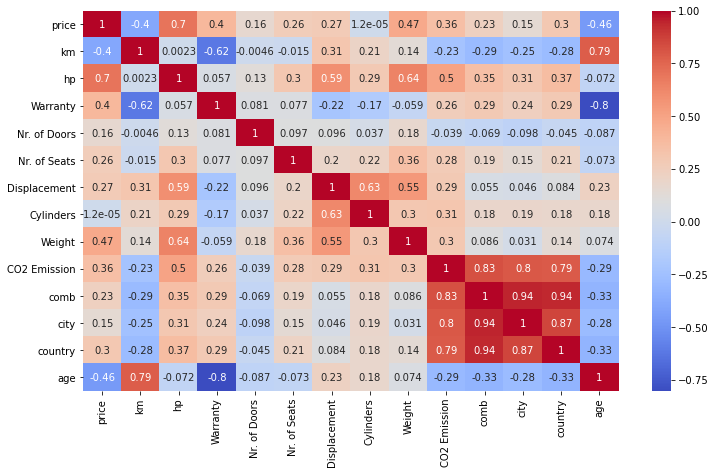

In [333]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.subplots(figsize = (12,7))
sns.heatmap(cars.corr(), cmap = "coolwarm", annot = True)

In [334]:
def outlier(col):
    for i in cars.make_model.unique():
        for j in cars.Displacement.unique():
            for k in cars.Fuel2.unique():
            
                    x = cars[col][(cars.make_model == i) & (cars.Displacement == j) & (cars.Fuel2 == k)]
                    cars[col][(cars.make_model == i) & (cars.Displacement == j) & (cars.Fuel2 == k)] = np.log(x)
            

In [335]:
outlier("CO2 Emission") # The values were grouped according to the corr. value and logged.

In [336]:
cars["CO2 Emission"]

0        4.595120
1        4.859812
2        4.595120
3        4.595120
4        4.691348
           ...   
15914    4.934474
15915    5.123964
15916    4.934474
15917    4.934474
15918    5.030438
Name: CO2 Emission, Length: 15919, dtype: float64

<AxesSubplot:>

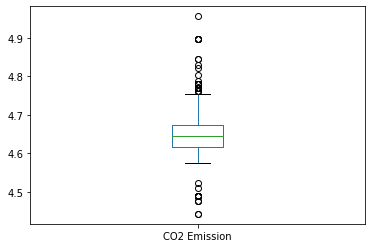

In [337]:
cars["CO2 Emission"][(cars.make_model == "Audi A3") & (cars.Displacement == 1598) & (cars.Fuel2 == "diesel")].plot(kind="box")

<AxesSubplot:ylabel='Frequency'>

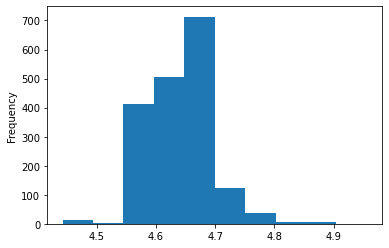

In [338]:
cars["CO2 Emission"][(cars.make_model == "Audi A3") & (cars.Displacement == 1598) & (cars.Fuel2 == "diesel")].plot(kind="hist")

In [339]:
def outlier(col):
    for i in cars.make_model.unique():
        for j in cars.Displacement.unique():
            for k in cars.hp.unique():
            
            
                    x = cars[col][(cars.make_model == i) & (cars.Displacement == j) & (cars.hp == k)]
                    cars[col][(cars.make_model == i) & (cars.Displacement == j) & (cars.hp == k)] = np.log(x)

In [340]:
outlier("Weight") # The values were grouped according to the corr. value and logged.

In [341]:
cars.loc[9279, "km"] = 31700 # The values thought to be entered incorrectly were corrected manually.

In [342]:
def outlier(col):
    for i in range(4):
        x = cars[col][(cars.km//12 == i)]
        cars[col][(cars.make_model == i)] = np.log(x)               

In [343]:
outlier("km") # km values logged for car age and make_model

In [344]:
cars.corr()

,price,km,hp,Warranty,Nr. of Doors,Nr. of Seats,Displacement,Cylinders,Weight,CO2 Emission,comb,city,country,age
price,1.000000,-0.400925,0.697856,0.399892,0.163380,0.263834,0.274819,0.000012,0.485123,0.347137,0.233939,0.151721,0.296447,-0.459090
km,-0.400925,1.000000,0.002686,-0.620843,-0.003318,-0.014766,0.311402,0.210634,0.140764,-0.240862,-0.287135,-0.247864,-0.279304,0.790019
hp,0.697856,0.002686,1.000000,0.057480,0.125208,0.303373,0.594147,0.290560,0.661083,0.487513,0.354889,0.306718,0.370019,-0.071898
Warranty,0.399892,-0.620843,0.057480,1.000000,0.080596,0.077308,-0.215761,-0.166286,-0.056395,0.264057,0.292481,0.243275,0.288721,-0.803502
Nr. of Doors,0.163380,-0.003318,0.125208,0.080596,1.000000,0.097402,0.096374,0.037488,0.179193,-0.046831,-0.068832,-0.098149,-0.044802,-0.087283
Nr. of Seats,0.263834,-0.014766,0.303373,0.077308,0.097402,1.000000,0.196195,0.217879,0.355827,0.289470,0.191861,0.145880,0.214188,-0.073287
Displacement,0.274819,0.311402,0.594147,-0.215761,0.096374,0.196195,1.000000,0.625149,0.572090,0.268889,0.054703,0.045689,0.084434,0.229331
Cylinders,0.000012,0.210634,0.290560,-0.166286,0.037488,0.217879,0.625149,1.000000,0.315649,0.306162,0.183438,0.185481,0.175829,0.177633
Weight,0.485123,0.140764,0.661083,-0.056395,0.179193,0.355827,0.572090,0.315649,1.000000,0.290116,0.081356,0.024317,0.139130,0.069776
CO2 Emission,0.347137,-0.240862,0.487513,0.264057,-0.046831,0.289470,0.268889,0.306162,0.290116,1.000000,0.824469,0.795929,0.786850,-0.299717


In [345]:
def outlier(col):
    for i in cars.make_model.unique():
        for k in cars.hp.unique():
            for n in range(4):
                x = cars[col][(cars.make_model == i)  & (cars.hp == k) & (cars.age//12 == n)]
                cars[col][(cars.make_model == i) & (cars.hp == k) & (cars.age//12 == n)] = np.log(x)

In [346]:
outlier("price") # The values were grouped according to the corr. value and logged.

In [347]:
cars["Nr. of Doors"] = cars["Nr. of Doors"].astype(str)
cars["Nr. of Doors"] # converted into object

0        5
1        3
2        4
3        3
4        5
        ..
15914    5
15915    5
15916    5
15917    5
15918    5
Name: Nr. of Doors, Length: 15919, dtype: object

In [348]:
cars["Nr. of Seats"] = cars["Nr. of Seats"].astype(str)
cars["Nr. of Seats"] # converted into object

0        5
1        4
2        4
3        4
4        5
        ..
15914    5
15915    5
15916    7
15917    7
15918    5
Name: Nr. of Seats, Length: 15919, dtype: object

In [349]:
cars["Displacement"] = cars["Displacement"].astype(str)
cars["Displacement"] # converted into object

0        1398
1        1798
2        1598
3        1398
4        1398
         ... 
15914    1998
15915    1798
15916    1998
15917    1998
15918    1798
Name: Displacement, Length: 15919, dtype: object

In [350]:
cars["Cylinders"] = cars["Cylinders"].astype(str)
cars["Cylinders"] # converted into object

0        3
1        4
2        4
3        3
4        3
        ..
15914    4
15915    4
15916    4
15917    4
15918    4
Name: Cylinders, Length: 15919, dtype: object

In [351]:
cars.dtypes

make_model                           object
short_description                    object
body_type                            object
price                               float64
vat                                  object
km                                    int32
registration                 datetime64[ns]
prev_owner                           object
hp                                    int32
Warranty                              int64
Body Color                           object
Paint Type                           object
Nr. of Doors                         object
Nr. of Seats                         object
Gearing Type                         object
Displacement                         object
Cylinders                            object
Weight                              float64
Drive chain                          object
CO2 Emission                        float64
Emission Class                       object
\nComfort & Convenience\n            object
\nEntertainment & Media\n       

## all columns are converted to numeric.

In [352]:
a = cars["\nComfort & Convenience\n"].str.get_dummies(sep = ",")
a

,Air conditioning,Air suspension,Armrest,Automatic climate control,Auxiliary heating,Cruise control,Electric Starter,Electric tailgate,Electrical side mirrors,Electrically adjustable seats,...,Power windows,Rain sensor,Seat heating,Seat ventilation,Split rear seats,Start-stop system,Sunroof,Tinted windows,Wind deflector,Windshield
0,1,0,1,1,0,1,0,0,1,0,...,1,1,1,0,0,1,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2,1,0,0,0,0,1,0,0,1,0,...,1,0,1,0,0,1,0,0,0,0
3,0,1,1,0,1,0,0,0,1,0,...,1,1,1,0,1,1,0,0,0,0
4,1,0,1,1,0,0,0,0,1,0,...,1,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15914,1,0,0,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,1,0,0
15915,1,0,0,1,0,1,0,1,1,0,...,1,1,1,0,0,0,1,0,0,0
15916,1,0,1,1,0,1,0,1,1,0,...,1,1,1,1,0,0,1,0,0,0
15917,1,0,0,1,0,1,0,0,1,1,...,1,0,0,0,0,1,0,0,0,0


In [353]:
b = cars["\nEntertainment & Media\n"].str.get_dummies(sep = ",")
b

,Bluetooth,CD player,Digital radio,Hands-free equipment,MP3,On-board computer,Radio,Sound system,Television,USB
0,1,0,0,1,0,1,1,0,0,0
1,1,0,0,1,0,1,1,1,0,0
2,0,0,0,0,1,1,0,0,0,0
3,1,1,0,1,1,1,1,1,0,1
4,1,1,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
15914,1,0,1,1,0,1,1,0,0,1
15915,1,0,1,1,0,0,1,0,0,1
15916,1,0,0,1,0,1,1,0,0,0
15917,1,0,1,0,0,0,1,0,0,1


In [354]:
c = cars["\nExtras\n"].str.get_dummies(sep = ",")
c

,Alloy wheels,Cab or rented Car,Catalytic Converter,Handicapped enabled,Right hand drive,Roof rack,Shift paddles,Ski bag,Sliding door,Sport package,Sport seats,Sport suspension,Touch screen,Trailer hitch,Tuned car,Voice Control,Winter tyres
0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15914,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
15915,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
15916,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15917,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [355]:
d = cars["\nSafety & Security\n"].str.get_dummies(sep = ",")
d

,ABS,Adaptive Cruise Control,Adaptive headlights,Alarm system,Blind spot monitor,Central door lock,Central door lock with remote control,Daytime running lights,Driver drowsiness detection,Driver-side airbag,...,Lane departure warning system,Night view assist,Passenger-side airbag,Power steering,Rear airbag,Side airbag,Tire pressure monitoring system,Traction control,Traffic sign recognition,Xenon headlights
0,1,0,0,0,0,1,0,1,0,1,...,0,0,1,1,0,1,1,1,0,1
1,1,0,0,0,0,1,1,1,0,1,...,0,0,1,1,0,1,1,1,0,1
2,1,0,0,0,0,1,0,1,0,1,...,0,0,1,1,0,1,1,1,0,0
3,1,0,0,1,0,0,1,0,1,1,...,0,0,1,1,0,1,1,0,0,0
4,1,0,0,0,0,1,0,0,0,1,...,0,0,1,1,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15914,1,0,0,0,0,1,1,0,0,1,...,1,0,1,1,1,1,1,1,1,0
15915,1,1,0,0,1,1,0,1,0,1,...,1,0,1,1,0,1,1,1,1,0
15916,1,1,0,0,1,1,0,1,0,1,...,1,0,1,1,0,1,0,1,1,0
15917,1,0,0,0,1,0,0,0,0,1,...,0,0,1,1,0,1,1,0,1,0


In [356]:
cars.drop("short_description", axis = 1, inplace = True) # short_description colm. dropped

In [357]:
cars.drop(["\nComfort & Convenience\n", "\nEntertainment & Media\n", "\nExtras\n" ,"\nSafety & Security\n"], axis = 1,\
          inplace = True ) # columns converted to numeric have been deleted

In [358]:
cars_new = pd.concat([cars, a, b, c, d], axis = 1) # numeric columns are concanated with cars df

In [359]:
cars_new

,make_model,body_type,price,vat,km,registration,prev_owner,hp,Warranty,Body Color,...,Lane departure warning system,Night view assist,Passenger-side airbag,Power steering,Rear airbag,Side airbag,Tire pressure monitoring system,Traction control,Traffic sign recognition,Xenon headlights
0,Audi A1,Sedans,9.665865,VAT deductible,56013,2016-01-01,2 previous owners,66,0,Black,...,0,0,1,1,0,1,1,1,0,1
1,Audi A1,Sedans,9.581904,Price negotiable,80000,2017-03-01,1 previous owner,141,3,Red,...,0,0,1,1,0,1,1,1,0,1
2,Audi A1,Sedans,9.591513,VAT deductible,83450,2016-02-01,1 previous owner,85,0,Black,...,0,0,1,1,0,1,1,1,0,0
3,Audi A1,Sedans,9.581904,VAT deductible,73000,2016-08-01,1 previous owner,66,0,Brown,...,0,0,1,1,0,1,1,0,0,0
4,Audi A1,Sedans,9.728539,VAT deductible,16200,2016-05-01,1 previous owner,66,0,Black,...,0,0,1,1,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15914,Renault Espace,Van,10.595384,VAT deductible,0,2019-04-01,no previous owner,147,36,Grey,...,1,0,1,1,1,1,1,1,1,0
15915,Renault Espace,Van,10.593756,VAT deductible,9900,2018-10-01,1 previous owner,165,22,Grey,...,1,0,1,1,0,1,1,1,1,0
15916,Renault Espace,Van,10.593505,VAT deductible,0,2019-03-01,no previous owner,146,27,White,...,1,0,1,1,0,1,0,1,1,0
15917,Renault Espace,Van,10.589106,VAT deductible,0,2019-06-01,no previous owner,147,30,Grey,...,0,0,1,1,0,1,1,0,1,0


In [360]:
cars_new.registration.apply(lambda x: x.toordinal())

0        735964
1        736389
2        735995
3        736177
4        736085
          ...  
15914    737150
15915    736968
15916    737119
15917    737211
15918    737060
Name: registration, Length: 15919, dtype: int64

In [361]:
cars_new["registration"] = cars_new.registration.apply(lambda x: x.toordinal())
# registration column was converted to numeric

In [362]:
cars_new = pd.get_dummies(cars_new) # categorical columns converted to numeric

In [363]:
cars_new.head()

,price,km,registration,hp,Warranty,Weight,CO2 Emission,comb,city,country,...,upholstery_type_Part leather,upholstery_color_ Beige,upholstery_color_ Black,upholstery_color_ Blue,upholstery_color_ Brown,upholstery_color_ Grey,upholstery_color_ Orange,upholstery_color_ Other,upholstery_color_ Red,upholstery_color_ White
0,9.665865,56013,735964,66,0,7.106606,4.595120,3.8,4.3,3.5,...,0,0,1,0,0,0,0,0,0,0
1,9.581904,80000,736389,141,3,7.134891,4.859812,5.6,7.1,4.7,...,0,0,0,0,0,1,0,0,0,0
2,9.591513,83450,735995,85,0,7.060476,4.595120,3.8,4.4,3.4,...,0,0,1,0,0,0,0,0,0,0
3,9.581904,73000,736177,66,0,7.085901,4.595120,3.8,4.3,3.5,...,0,0,1,0,0,0,0,0,0,0
4,9.728539,16200,736085,66,0,7.060476,4.691348,4.1,4.6,3.8,...,0,0,1,0,0,0,0,0,0,0


In [364]:
cars_new.shape

(15919, 208)

In [365]:
cars_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15919 entries, 0 to 15918
Columns: 208 entries, price to upholstery_color_ White
dtypes: float64(6), int32(2), int64(97), uint8(103)
memory usage: 14.2 MB


In [366]:
cars_new.isnull().sum().sum()

0

In [367]:
cars_new.to_csv("cars_new2.csv", index = False)

In [368]:
pd.read_csv("cars_new2.csv").head()

,price,km,registration,hp,Warranty,Weight,CO2 Emission,comb,city,country,...,upholstery_type_Part leather,upholstery_color_ Beige,upholstery_color_ Black,upholstery_color_ Blue,upholstery_color_ Brown,upholstery_color_ Grey,upholstery_color_ Orange,upholstery_color_ Other,upholstery_color_ Red,upholstery_color_ White
0,9.665865,56013,735964,66,0,7.106606,4.595120,3.8,4.3,3.5,...,0,0,1,0,0,0,0,0,0,0
1,9.581904,80000,736389,141,3,7.134891,4.859812,5.6,7.1,4.7,...,0,0,0,0,0,1,0,0,0,0
2,9.591513,83450,735995,85,0,7.060476,4.595120,3.8,4.4,3.4,...,0,0,1,0,0,0,0,0,0,0
3,9.581904,73000,736177,66,0,7.085901,4.595120,3.8,4.3,3.5,...,0,0,1,0,0,0,0,0,0,0
4,9.728539,16200,736085,66,0,7.060476,4.691348,4.1,4.6,3.8,...,0,0,1,0,0,0,0,0,0,0
